In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy.signal import convolve2d
from scipy.stats import norm

### test image

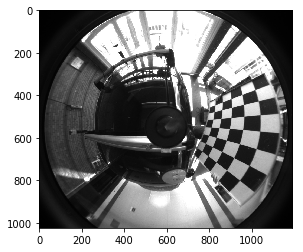

In [4]:
image = plt.imread('../data/01.png')
plt.imshow(image, cmap = 'gray')

## createCorrelationPatch.m
done

In [5]:
class Template:
    def __init__(self, height, width):
        self.a1 = np.zeros((height, width))
        self.b1 = np.zeros((height, width))
        self.a2 = np.zeros((height, width))
        self.b2 = np.zeros((height, width))
        
    def do_normalize(self):
        self.a1 = self.a1 / np.sum(self.a1)
        self.a2 = self.a2 / np.sum(self.a2)
        self.b1 = self.b1 / np.sum(self.b1)
        self.b2 = self.b2 / np.sum(self.b2)
        

def createCorrelationPatch(properties):
    angle_1, angle_2, radius = properties
    
    width  = radius*2 + 1
    height = radius*2 + 1
    
    # initialize template
    template = Template(height, width)
    
    # midpoint
    mu = radius + 1
    mv = radius + 1

    # compute normals from angles
    n1 = [-np.sin(angle_1), np.cos(angle_1)]
    n2 = [-np.sin(angle_2), np.cos(angle_2)]
    
    # for all points in template do
    for u in range(0, width):
        for v in range(0, height):
            # vector
            vec = [u-mu+1, v-mv+1]
            dist = np.linalg.norm(vec)
            
            # check on which side of the normals we are
            s1 = np.matmul(vec, np.transpose(n1))
            s2 = np.matmul(vec, np.transpose(n2))
            
            if (s1 <= -0.1 and s2 <= -0.1):
                template.a1[v][u] = norm.pdf(dist, 0, radius/2) # x, mu, sigma 
            elif (s1 >= 0.1 and s2 >= 0.1):
                template.a2[v][u] = norm.pdf(dist, 0, radius/2)
            elif (s1 <= -0.1 and s2 >= 0.1):
                template.b1[v][u] = norm.pdf(dist, 0, radius/2) 
            elif (s1 >= 0.1 and s2 <= 0-.1):
                template.b2[v][u] = norm.pdf(dist, 0, radius/2)
                
    # normalize
    template.do_normalize()
    
    return template

## nonMaximumSuppression.m
maxima different

In [6]:
def nonMaximumSuppression(img, n, tau, margin):
    height, width = img.shape
    maxima = []
    for i in range(n+margin, width-n-margin, n+1):
        for j in range(n+margin, height-n-margin, n+1):
            # initial value
            maxi, maxj = i, j
            maxval = img[j][i]
            # update maxval if found
            for i2 in range(i, i+n):
                for j2 in range(j, j+n):
                    if (img[j2][i2] > maxval):
                        maxi, maxj = i2, j2
                        maxval = img[j2][i2]

            failed = 0
            for i2 in range(maxi-n, min(maxi+n, width-margin)):
                for j2 in range(maxj-n, min(maxj+n, height-margin)):
                    currval = img[j2][i2]
                    if (currval>maxval and (i2<i or i2>i+n or j2<j or j2>j+n)):
                        failed = 1
                        break
                if (failed):
                    break

            if (maxval >= tau and failed == 0):
                maxima.append([maxi, maxj])

    maxima = np.array(maxima)
    
    return maxima

## findCorners.m

In [7]:
def findCorners(img, tau):
    
    # filter image
    print('Start Filtering ...')
    
    # use 3 scales to obtain a modest level of scale invariance and robustness w.r.t blur
    radius = [4, 8, 12]

    # template properties     
    template_props = [[      0,  np.pi/2, radius[0]],
                      [np.pi/4, -np.pi/4, radius[0]],
                      [      0,  np.pi/2, radius[1]],
                      [np.pi/4, -np.pi/4, radius[1]],
                      [      0,  np.pi/2, radius[2]],
                      [np.pi/4, -np.pi/4, radius[2]]]
        
    img_corners = np.zeros(img.shape)
    for i in range(0, len(template_props)):
        # create correlation template
        template = createCorrelationPatch(template_props[i])
    
        # filter image according with current template
        img_corners_a1 = convolve2d(img, template.a1, 'same')
        img_corners_a2 = convolve2d(img, template.a2, 'same')
        img_corners_b1 = convolve2d(img, template.b1, 'same')
        img_corners_b2 = convolve2d(img, template.b2, 'same')
        
        # compute mean
        img_corners_mu = (img_corners_a1+img_corners_a2+img_corners_b1+img_corners_b2)/4
        # case 1: a=white, b=black
        img_corners_a = np.minimum(np.subtract(img_corners_a1, img_corners_mu), np.subtract(img_corners_a2, img_corners_mu))
        img_corners_b = np.minimum(np.subtract(img_corners_mu, img_corners_b1), np.subtract(img_corners_mu, img_corners_b2))
        img_corners_1 = np.minimum(img_corners_a, img_corners_b)
        
        # case 2: a=black, b=white
        img_corners_a = np.minimum(np.subtract(img_corners_mu, img_corners_a1), np.subtract(img_corners_mu, img_corners_a2))
        img_corners_b = np.minimum(np.subtract(img_corners_b1, img_corners_mu), np.subtract(img_corners_b2, img_corners_mu))
        img_corners_2 = np.minimum(img_corners_a, img_corners_b)
        
        # update corner map
        img_corners = np.maximum(img_corners, img_corners_1)
        img_corners = np.maximum(img_corners, img_corners_2)
        
    return img_corners

## compute image derivatives

In [8]:
def get_img_derivatives(img):
    
    # sobel masks
    du = [[-1,  0,  1],
          [-1,  0,  1],
          [-1,  0,  1]]
    
    dv = [[-1, -1, -1],
          [ 0,  0,  0],
          [ 1,  1,  1]]
    
    img_du = convolve2d(img, du, mode = 'same')
    img_dv = convolve2d(img, dv, mode = 'same')
    img_angle = np.arctan2(img_dv, img_du)
    img_weight = np.sqrt(img_du**2 + img_dv**2)
    
    # correct angle to lie in between [0,pi]
    h, w = img_angle.shape
    for i in range(0, h):
        for j in range(0, w):
            if(img_angle[i][j] < 0):
                img_angle[i][j] += np.pi
            elif(img_angle[i][j] > np.pi):
                img_angle[i][j] -= np.pi
    
    return img_du, img_dv, img_angle, img_weight

## findModesMeanShift.m
done

In [9]:
def findModesMeanShift(hist, sigma):
    # efficient mean-shift approximation by histogram smoothing
    
    # compute smoothed histogram
    hist_smoothed = np.zeros((len(hist)))
    for i in range(0, len(hist)):
        j = np.arange(-np.round(2*sigma), np.round(2*sigma)+1)
        idx = np.mod(i+j, len(hist))
        hist_smoothed[i] = np.sum(hist[idx] * norm.pdf(j, 0, sigma))

    modes = []
    # check if at least one entry is non-zero
    # (otherwise mode finding may run infinitly)
    if np.abs(hist_smoothed - hist_smoothed[0]).any() < 1e-5:
        return
    
    modes = np.empty((0, 2), float)
    # mode finding
    for i in range(0, len(hist_smoothed)):
        j = i
        while(1):
            j1 = np.mod(j+1, len(hist))
            j2 = np.mod(j-1, len(hist))
            h0 = hist_smoothed[j]
            h1 = hist_smoothed[j1]
            h2 = hist_smoothed[j2]
            if (h1 >= h0 and h1 >= h2):
                j = j1
            elif (h2 > h0 and h2 > h1):
                j = j2
            else:
                break

        if len(modes) == 0:
            modes = np.array([[j, hist_smoothed[j]]])
        elif (j not in modes[:,0]):    
            new = np.array([[j, hist_smoothed[j]]])
            modes = np.concatenate((modes, new))

    # sort in descending order
    modes = modes[np.argsort(-modes[:,1])]
    
    return modes, hist_smoothed

## refineCorners.m

In [13]:
class Corners:
    def __init__(self, NMS_corners):
        
        self.p = NMS_corners
        # init orientations to invalid (corner is invalid iff orientation=0)
        self.v1 = np.zeros(NMS_corners.shape)
        self.v2 = np.zeros(NMS_corners.shape)

In [14]:
def refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, r):

    corners = Corners(NMS_corners)
    height, width = img_du.shape

    # for all corners do
    for i in range(0, len(corners.p)):
        # extract current corner location
        cu, cv = corners.p[i]
        
        # estimate edge orientations
        img_angle_sub  = img_angle[max(cv-r,1):min(cv+r,height), max(cu-r,1):min(cu+r,width)]
    
    
    return None

### refine corners

In [15]:
def edgeOrientations(img_angle, img_weight):
    # init v1 and v2
    v1 = [0, 0]
    v2 = [0, 0]
    
    # number of bins (histogram parameters)
    bin_num = 32
    
    # convert images to vectors
    vec_angle = img_angle.T.reshape(-1)
    vec_weight = img_weight.T.reshape(-1)
    
    # convert angles from normals to directions
    vec_angle = vec_angle + np.pi/2
    vec_angle[vec_angle > np.pi] -= np.pi
    
    #create histogram
    angle_hist = np.zeros((bin_num))
    for i in range(0, len(vec_angle)):
        bin = int(max(min(np.floor(vec_angle[i]/(np.pi/bin_num)),bin_num-1), 0))
        angle_hist[bin] = angle_hist[bin]+vec_weight[i];
    
    modes, angle_hist_smoothed = findModesMeanShift(angle_hist,1);
    
    
    # if only one or no mode => return invalid corner
    if (len(modes) <= 1):
        return v1, v2
    
    # compute orientation at modes
    new =  modes[:,0]*np.pi / bin_num
    new = np.reshape(new, (-1, 1))
    modes = np.hstack((modes,new))
    
    #extract 2 strongest modes and sort by angle
    modes = modes[:2]
    modes = modes[np.argsort(modes[:,2])]
    
    # compute angle between modes
    delta_angle = min(modes[1, 2] - modes[0, 2], modes[0, 2] + np.pi - modes[1, 2])

    # if angle too small => return invalid corner
    if (delta_angle <= 0.3):
        return v1, v2
    
    # set statistics: orientations
    v1 = [np.cos(modes[0, 2]), np.sin(modes[0, 2])]
    v2 = [np.cos(modes[1, 2]), np.sin(modes[1, 2])]
    
    return v1, v2

In [83]:
r = 10
corners = Corners(NMS_corners)
height, width = img_du.shape

# for all corners do
#for i in range(0, 1): ########delete this line
for i in range(0, len(corners.p)):
    # extract current corner location
    cu, cv = corners.p[i]

    # estimate edge orientations
    img_angle_sub  = img_angle[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
    img_weight_sub = img_weight[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
    v1, v2 = edgeOrientations(img_angle_sub, img_weight_sub)
    
    # continue, if invalid edge orientations
    if (v1 == [0, 0] or v2 == [0, 0]):
        continue
    corners.v1[i] = v1
    corners.v2[i] = v2
    #################################
    # corner orientation refinement #
    #################################
    
    A1 = np.zeros((2,2))
    A2 = np.zeros((2,2))
    
    for u in range(max(cu-r, 0), min(cu+r, width)):
        for v in range(max(cu-r, 0), min(cu+r, height)):
            # pixel orientation vector
            o = [img_du[v, u], img_dv[v, u]]
            if (np.linalg.norm(o) < 0.1):
                continue
            o = o / np.linalg.norm(o)
            print(o)
            # robust refinement of orientation 1
            if(np.abs(np.matmul(o, v1))<0.25): # inlier?
                A1[0,:] = A1[0, :] + [img_du[v, u], img_dv[v, u]]
                print(A1)
                print('=='*10)


[-0.77724486 -0.62919824]
[[-0.08235294 -0.06666667]
 [ 0.          0.        ]]
[-0.77724486 -0.62919824]
[-0.78750499 -0.61630827]
[-0.81602447 -0.57801735]
[-0.79543171 -0.60604322]
[-0.76822127 -0.64018441]
[-0.78750499 -0.61630827]
[-0.95879812 -0.2840883 ]
[-0.70710678 -0.70710678]
[-0.67091333 -0.74153578]
[-0.69047575 -0.72335554]
[-0.77724486 -0.62919824]
[-0.78750499 -0.61630827]
[-0.81602447 -0.57801735]
[-0.79543171 -0.60604322]
[-0.76822127 -0.64018441]
[-0.78750499 -0.61630827]
[-0.95879812 -0.2840883 ]
[-0.92096725  0.38963998]
[ 0.51994693 -0.85419857]
[-0.72595268 -0.68774465]
[-0.75460552 -0.65617872]
[-0.756823   -0.65361988]
[-0.86478894 -0.50213553]
[-0.86193422  0.50702011]
[-0.56468393  0.82530725]
[-0.80873609 -0.58817169]
[-0.77096177 -0.63688142]
[-0.41665468 -0.90906484]
[-0.45587586  0.89004337]
[-0.72499943 -0.68874946]
[-0.78750502 -0.61630823]
[-0.77395731 -0.63323778]
[-0.15205713  0.98837171]
[[-0.0235294   0.15294117]
 [ 0.          0.        ]]
[-0.25

[0.27881019 0.96034623]
[-0.87319772 -0.48736613]
[-0.99273379 -0.12033133]
[-0.91914506  0.39391924]
[[-0.21960785  0.09411763]
 [ 0.          0.        ]]
[-0.75740998  0.6529396 ]
[[-0.33333335  0.19215685]
 [ 0.          0.        ]]
[-0.22026078 -0.97544102]
[-0.60536747 -0.79594612]
[-0.96720097 -0.25401237]
[-0.79543175  0.60604317]
[[-0.66274514  0.44313724]
 [ 0.          0.        ]]
[-0.54147759  0.84071518]
[-0.10653318 -0.99430915]
[-0.56231008 -0.82692646]
[-0.92307692  0.38461539]
[[-0.7568628   0.48235293]
 [ 0.          0.        ]]
[-0.91914506  0.39391924]
[-0.75740998  0.6529396 ]
[-0.79543175  0.60604317]
[-0.54147759  0.84071518]
[[-0.14901962  0.23137257]
 [ 0.          0.        ]]
[-0.10653318 -0.99430915]
[-0.56231008 -0.82692646]
[-0.92307692  0.38461539]
[0.41288778 0.91078191]
[0.21540963 0.97652378]
[-0.07669654 -0.99705448]
[-0.25335945 -0.96737221]
[-0.462566    0.88658485]
[[-0.19607845  0.32156865]
 [ 0.          0.        ]]
[0.87641919 0.48154897]
[0

 [ 0.          0.        ]]
[-0.58430475  0.81153433]
[[ 0.44313724 -0.49019608]
 [ 0.          0.        ]]
[ 0.60508328 -0.79616219]
[[ 0.51764705 -0.5882353 ]
 [ 0.          0.        ]]
[ 0.47885211 -0.87789559]
[-0.4472136   0.89442719]
[ 0.51053875 -0.85985475]
[[ 0.59215686 -0.7137255 ]
 [ 0.          0.        ]]
[ 0.67426937 -0.73848549]
[[ 0.67450981 -0.80392159]
 [ 0.          0.        ]]
[-0.51994688  0.85419859]
[[ 0.61960785 -0.7137255 ]
 [ 0.          0.        ]]
[-0.65617872  0.75460552]
[[ 0.54117648 -0.62352942]
 [ 0.          0.        ]]
[ 0.64764842 -0.76193932]
[-0.37139075 -0.92847666]
[ 0.1104315  -0.99388374]
[[ 0.01176471 -0.10588237]
 [ 0.          0.        ]]
[ 0.68774465 -0.72595268]
[ 0.68874943 -0.72499946]
[ 0.96399262 -0.26592901]
[0.86478893 0.50213555]
[0.85419851 0.51994702]
[ 0.77395729 -0.6332378 ]
[ 0.57801735 -0.81602447]
[0.89442719 0.4472136 ]
[ 0.49613896 -0.86824313]
[ 0.5462678  -0.83761059]
[ 0.72499943 -0.68874946]
[-0.68774465  0.72595

[-0.72138732  0.69253183]
[[-0.80784322  0.95686284]
 [ 0.          0.        ]]
[-0.7592566   0.65079138]
[[-0.89019616  1.02745108]
 [ 0.          0.        ]]
[-0.67828011  0.73480344]
[[-0.98431382  1.12941187]
 [ 0.          0.        ]]
[-0.52256205  0.85260126]
[[-1.05882362  1.2509805 ]
 [ 0.          0.        ]]
[ 0.58123822 -0.81373345]
[[-1.00000008  1.16862755]
 [ 0.          0.        ]]
[-0.63473943  0.77272625]
[[-1.09019617  1.27843148]
 [ 0.          0.        ]]
[-0.75071354  0.66062787]
[[-1.18823539  1.36470599]
 [ 0.          0.        ]]
[ 0.7249994 -0.6887495]
[[-1.10980402  1.29019618]
 [ 0.          0.        ]]
[-0.75925664  0.65079133]
[[-1.21960796  1.38431383]
 [ 0.          0.        ]]
[-0.61217321  0.7907237 ]
[[-1.31372561  1.50588246]
 [ 0.          0.        ]]
[ 0.61630828 -0.78750499]
[[-1.24313737  1.41568638]
 [ 0.          0.        ]]
[ 0.62919824 -0.77724486]
[[-1.17647069  1.33333343]
 [ 0.          0.        ]]
[-0.58363601  0.8120154 ]
[[-1

 [ 0.          0.        ]]
[ 0.787505   -0.61630826]
[[ 0.39999998 -0.25098038]
 [ 0.          0.        ]]
[ 0.96034623 -0.27881019]
[[ 0.5215686  -0.28627449]
 [ 0.          0.        ]]
[ 0.9974587  -0.07124705]
[-0.7592566   0.65079138]
[[ 0.43921565 -0.21568625]
 [ 0.          0.        ]]
[-0.67828011  0.73480344]
[-0.52256205  0.85260126]
[-0.63473943  0.77272625]
[-0.75071354  0.66062787]
[[ 0.34117643 -0.12941174]
 [ 0.          0.        ]]
[-0.75925664  0.65079133]
[[ 0.23137249 -0.03529409]
 [ 0.          0.        ]]
[-0.61217321  0.7907237 ]
[ 0.61630828 -0.78750499]
[ 0.62919824 -0.77724486]
[-0.58363601  0.8120154 ]
[-0.67705651  0.73593104]
[ 0.80994211 -0.58650983]
[[ 0.34509799 -0.11764704]
 [ 0.          0.        ]]
[ 0.88047108 -0.47409987]
[[ 0.44705878 -0.17254902]
 [ 0.          0.        ]]
[-0.45942289  0.88821766]
[ 0.83957014 -0.5432513 ]
[[ 0.58039212 -0.25882354]
 [ 0.          0.        ]]
[ 0.81153433 -0.58430474]
[[ 0.67843134 -0.32941177]
 [ 0.      

[[ 0.33333329 -0.58039211]
 [ 0.          0.        ]]
[-0.60843156  0.79360635]
[[ 0.2431372  -0.46274505]
 [ 0.          0.        ]]
[ 0.64846646 -0.76124322]
[[ 0.33333329 -0.56862741]
 [ 0.          0.        ]]
[-0.64018441  0.76822127]
[[ 0.25490192 -0.47450976]
 [ 0.          0.        ]]
[-0.70710678  0.70710678]
[ 0.69253183 -0.72138732]
[-0.72264186  0.69122265]
[-0.76570486  0.6431921 ]
[-0.4472136  -0.89442719]
[-0.58363605 -0.81201537]
[-0.84964017 -0.52736286]
[-0.92401683 -0.38235179]
[-0.56231002 -0.8269265 ]
[-0.53217155 -0.84663655]
[-0.56030937 -0.82828341]
[-0.74329415 -0.66896473]
[-0.34731436 -0.93774876]
[-0.42288547 -0.90618314]
[-0.36244626 -0.93200467]
[-0.32507977 -0.9456866 ]
[ 0.03446228 -0.999406  ]
[ 0.28734789 -0.95782629]
[ 0.36565237 -0.93075149]
[ 0.51994695 -0.85419856]
[ 0.62070294 -0.78404582]
[ 0.65617871 -0.75460552]
[-0.33871947 -0.94088741]
[-0.07124705 -0.9974587 ]
[ 0.11462411 -0.99340894]
[-0.72335554  0.69047575]
[-0.67426937  0.73848549]


[ 0.8574929  -0.51449579]
[[ 0.25882354 -0.19607845]
 [ 0.          0.        ]]
[ 0.94088741 -0.33871947]
[[ 0.35686275 -0.23137257]
 [ 0.          0.        ]]
[ 0.07387169 -0.99726775]
[-0.76570486  0.6431921 ]
[[ 0.25882353 -0.14901961]
 [ 0.          0.        ]]
[ 0.79616219 -0.60508327]
[[ 0.35686274 -0.22352941]
 [ 0.          0.        ]]
[ 0.75682301 -0.65361987]
[[ 0.44313724 -0.29803921]
 [ 0.          0.        ]]
[-0.66257383  0.74899661]
[-0.68965514  0.72413796]
[[ 0.36470587 -0.21568626]
 [ 0.          0.        ]]
[ 0.5881717  -0.80873608]
[ 0.46256601 -0.88658485]
[-0.62139467  0.78349771]
[ 0.66896473 -0.74329414]
[[ 0.47058822 -0.33333332]
 [ 0.          0.        ]]
[-0.50571953  0.86269795]
[ 0.52999896 -0.84799829]
[ 0.60971077 -0.79262398]
[-0.46574647  0.88491821]
[ 0.66162164 -0.74983785]
[-0.61782157  0.78631833]
[ 0.25997347 -0.96561576]
[ 0.62469505 -0.7808688 ]
[ 0.58123816 -0.8137335 ]
[-0.63167296  0.77523498]
[-0.66601578  0.74593766]
[-0.12033137 -0.9

[ 0.24987802 -0.96827732]
[[ 0.29019608 -0.66666666]
 [ 0.          0.        ]]
[ 0.31622774 -0.94868331]
[[ 0.3372549  -0.80784313]
 [ 0.          0.        ]]
[ 0.70710673 -0.70710684]
[0.99654576 0.08304546]
[0.9670745  0.25449343]
[0.9792604 0.2026057]
[0.73715414 0.67572463]
[0.6804511  0.73279349]
[ 0.84481908 -0.53505208]
[ 0.90569023 -0.42394011]
[ 0.96046636 -0.27839608]
[ 0.99685119 -0.07929502]
[0.99792531 0.06438231]
[1.00000000e+00 4.52356686e-08]
[ 0.98994949 -0.14142136]
[ 0.97400803 -0.22651349]
[ 0.96296402 -0.26962993]
[0.7592566  0.65079137]
[0.70710678 0.70710678]
[0.64319209 0.76570486]
[0.99959208 0.02855983]
[0.99879284 0.04912099]
[0.99619372 0.08716694]
[0.99827437 0.05872202]
[ 0.99282013 -0.11961687]
[ 0.96866387 -0.24837533]
[ 0.95746454 -0.28855097]
[ 0.94714457 -0.32080705]
[ 0.98456251 -0.17503333]
[0.93887632 0.34425465]
[0.73715414 0.67572463]
[0.69122265 0.72264186]
[ 0.49972249 -0.86618556]
[[ 0.39607844 -0.90980393]
 [ 0.          0.        ]]
[-0.0

[-0.51449575  0.85749293]
[0.60604322 0.79543172]
[0.66436384 0.74740932]
[0.69190536 0.72198821]
[0.52999894 0.8479983 ]
[-0.12403471  0.99227788]
[-0.20952905  0.97780242]
[-0.99816849 -0.06049511]
[[1.56862757 0.19607852]
 [0.         0.        ]]
[0.64764842 0.76193932]
[0.67028626 0.74210264]
[0.73105527 0.68231825]
[0.29408589 0.955779  ]
[0.33282011 0.94299033]
[-0.92219436 -0.38672673]
[[1.44705893 0.14509812]
 [0.         0.        ]]
[-0.12033137 -0.99273378]
[-0.30224389 -0.95323063]
[0.82039822 0.57179259]
[0.67940804 0.73376067]
[0.6 0.8]
[0.5547002  0.83205029]
[-0.4472136  -0.89442719]
[-0.45631668 -0.88981745]
[-0.35112343 -0.93632918]
[0.79543181 0.6060431 ]
[0.67091332 0.74153578]
[0.80355719 0.59522755]
[0.69310872 0.72083306]
[ 0.33871947 -0.94088741]
[ 0.24987802 -0.96827732]
[ 0.31622774 -0.94868331]
[ 0.70710673 -0.70710684]
[[ 0.09411766 -0.09411767]
 [ 0.          0.        ]]
[0.99654576 0.08304546]
[0.9670745  0.25449343]
[0.9792604 0.2026057]
[0.73715414 0.6

[ 0.25997347 -0.96561576]
[-0.27472121 -0.96152392]
[-0.63688134 -0.77096184]
[-0.04540774 -0.99896854]
[ 0.7577688  -0.65252314]
[0.85606443 0.51686912]
[0.6357072  0.77193028]
[0.72499936 0.68874954]
[0.54212687 0.84029665]
[-0.12033137 -0.99273378]
[-0.30224389 -0.95323063]
[0.82039822 0.57179259]
[0.67940804 0.73376067]
[0.6 0.8]
[0.5547002  0.83205029]
[-0.4472136  -0.89442719]
[-0.45631668 -0.88981745]
[-0.35112343 -0.93632918]
[0.79543181 0.6060431 ]
[0.67091332 0.74153578]
[0.80355719 0.59522755]
[0.69310872 0.72083306]
[ 0.33871947 -0.94088741]
[ 0.24987802 -0.96827732]
[ 0.31622774 -0.94868331]
[ 0.70710673 -0.70710684]
[0.99654576 0.08304546]
[0.9670745  0.25449343]
[0.9792604 0.2026057]
[0.73715414 0.67572463]
[0.6804511  0.73279349]
[0.75460552 0.65617871]
[ 0.84481908 -0.53505208]
[ 0.90569023 -0.42394011]
[[ 0.18431371 -0.0862745 ]
 [ 0.          0.        ]]
[ 0.96046636 -0.27839608]
[[ 0.45490195 -0.16470589]
 [ 0.          0.        ]]
[ 0.99685119 -0.07929502]
[[ 0.8

[ 0.99944491 -0.03331483]
[ 0.98200645 -0.18884739]
[0.67028626 0.74210264]
[0.61394065 0.78935219]
[-0.76822127  0.64018441]
[[-0.08235295  0.01176472]
 [ 0.          0.        ]]
[-0.88311572  0.46915522]
[-0.75460552  0.65617872]
[[-0.17254903  0.0901961 ]
 [ 0.          0.        ]]
[-0.12716436 -0.99188166]
[-0.13819606 -0.99040489]
[ 0.96351792 -0.26764384]
[ 0.98418332 -0.17715301]
[ 0.99792531 -0.06438227]
[ 0.98364749 -0.18010446]
[ 0.98110855 -0.19345804]
[ 0.99025658 -0.13925486]
[ 0.99227788 -0.12403473]
[0.54075757 0.84117849]
[-0.93075149  0.36565238]
[-0.72083306  0.69310872]
[[-0.27450982  0.18823532]
 [ 0.          0.        ]]
[-0.51449575  0.85749293]
[[-0.34509806  0.30588239]
 [ 0.          0.        ]]
[-0.86478894 -0.50213553]
[-0.67349    -0.73919633]
[-0.78086883 -0.62469502]
[-0.99139051 -0.13093836]
[-0.98687458  0.16148859]
[-0.99913307  0.04163054]
[-0.95879814  0.28408825]
[ 0.9486833  -0.31622777]
[ 0.971399  -0.2374531]
[ 0.99503719 -0.09950371]
[-0.1240

[-0.57346236 -0.81923191]
[-0.7320186  -0.68128464]
[-0.80873609 -0.58817168]
[-0.83165273 -0.55529607]
[-0.83106547 -0.5561746 ]
[0.88068524 0.47370191]
[-0.65736876  0.75356905]
[-0.67904198  0.73409944]
[ 0.61144744 -0.79128504]
[ 0.55470018 -0.8320503 ]
[ 0.39643602 -0.91806235]
[ 0.34506559 -0.93857857]
[ 0.16896379 -0.98562226]
[[-0.04705884 -0.85490204]
 [ 0.          0.        ]]
[-0.4061385  -0.91381153]
[-0.56254315 -0.82676793]
[-0.58852512 -0.80847893]
[-0.54694859 -0.8371662 ]
[ 0.65203927 -0.7581852 ]
[0.89378556 0.44849456]
[0.88289148 0.46957708]
[-0.72007789  0.69389324]
[-0.67976467  0.73343029]
[ 0.32507977 -0.9456866 ]
[[-0.00392158 -0.98039225]
 [ 0.          0.        ]]
[ 0.67705659 -0.73593096]
[ 0.79262399 -0.60971076]
[ 0.45477716 -0.89060526]
[-0.06370015 -0.99796908]
[[-0.02745099 -1.34901972]
 [ 0.          0.        ]]
[-0.46283404 -0.88644495]
[-0.63059261 -0.77611401]
[-0.45061119 -0.89272031]
[ 0.06359645 -0.9979757 ]
[[ 0.02352937 -2.1490197 ]
 [ 0.   

[0.78601178 0.61821152]
[0.78958323 0.61364348]
[0.76822128 0.6401844 ]
[0.74382992 0.66836894]
[0.79999999 0.60000001]
[0.87929197 0.47628314]
[-0.44721357 -0.8944272 ]
[-0.53838927 -0.84269627]
[-0.61782149 -0.78631839]
[-0.91806234  0.39643604]
[-0.9769897  -0.21328647]
[-0.74395831 -0.66822603]
[-0.75109302 -0.66019639]
[-0.64261222 -0.76619158]
[0.87862457 0.47751322]
[0.7888826  0.61454393]
[0.79690464 0.60410512]
[0.79101311 0.61179919]
[0.77979615 0.62603352]
[0.81373346 0.58123821]
[0.85165828 0.52409749]
[-0.72032021 -0.69364169]
[-0.71672593 -0.69735496]
[-0.74983785 -0.66162164]
[ 0.12625428 -0.99199791]
[-0.86412312 -0.50328048]
[-0.91939914 -0.39332583]
[-0.85831501 -0.51312313]
[-0.88047116 -0.47409972]
[0.76413864 0.64505204]
[0.77713384 0.62933536]
[0.73462402 0.67847442]
[0.71435858 0.69977984]
[0.75071351 0.6606279 ]
[0.78349771 0.62139467]
[0.85749293 0.51449575]
[-0.68315713 -0.73027141]
[-0.69678569 -0.71727938]
[-0.69542143 -0.71860214]
[-0.63167295 -0.77523499]


[-0.66679486 -0.74524131]
[-0.78935222 -0.61394061]
[-0.77523499 -0.63167295]
[-0.68394113 -0.7295372 ]
[-0.80246236 -0.59670274]
[-0.7878072  -0.61592192]
[0.69476909 0.71923286]
[0.7238689  0.68993755]
[0.71692627 0.697149  ]
[0.70710677 0.70710679]
[0.64668522 0.76275699]
[-0.84029666 -0.54212686]
[-0.83844363 -0.54498832]
[-0.80873608 -0.58817171]
[-0.74329414 -0.66896473]
[-0.71860214 -0.69542143]
[-0.80355719 -0.59522755]
[-0.73848549 -0.67426936]
[-0.66561481 -0.74629546]
[-0.71984429 -0.69413557]
[-0.80394722 -0.59470066]
[-0.92219436 -0.38672673]
[-0.81201536 -0.58363607]
[-0.56084816 -0.82791868]
[0.99931483 0.03701166]
[0.95242415 0.30477573]
[-0.99951207  0.03123481]
[-0.99570122 -0.09262336]
[-1.  0.]
[-0.99681528  0.07974521]
[-0.98588656  0.16741472]
[[-0.20784315  0.03529412]
 [ 0.          0.        ]]
[-0.99607264  0.08853978]
[ 0.67828008 -0.73480347]
[ 0.89442719 -0.4472136 ]
[[ 0.01960782 -0.07843136]
 [ 0.          0.        ]]
[ 0.91121949 -0.41192116]
[[ 0.30588

[0.65079137 0.7592566 ]
[0.71973062 0.69425343]
[0.72155399 0.69235817]
[0.76124322 0.64846646]
[0.82465839 0.5656311 ]
[ 0.45477716 -0.89060526]
[[-0.35294122  0.27843145]
 [ 0.          0.        ]]
[-0.06370015 -0.99796908]
[-0.46283404 -0.88644495]
[-0.63059261 -0.77611401]
[-0.45061119 -0.89272031]
[ 0.06359645 -0.9979757 ]
[ 0.96913412 -0.24653408]
[0.94937906 0.31413278]
[0.8912359  0.45354004]
[0.8924996  0.45104818]
[0.97355527 0.2284516 ]
[ 0.94584051 -0.32463168]
[ 0.81232372 -0.5832068 ]
[ 0.86637449 -0.49939488]
[ 0.99828984 -0.05845841]
[0.9317774  0.36303012]
[0.85906806 0.51186137]
[0.79499906 0.60661066]
[0.8006714  0.59910376]
[0.7907237  0.61217321]
[-0.65661799 -0.75422332]
[-0.68774465 -0.72595268]
[-0.7560238  -0.65454412]
[-0.59539904 -0.80343014]
[ 0.59726616 -0.8020431 ]
[[-0.0784314  -0.09019601]
 [ 0.          0.        ]]
[ 0.99552807 -0.09446614]
[0.97773256 0.20985481]
[0.92554696 0.37863283]
[0.89385531 0.44835553]
[0.91669596 0.39958543]
[0.99414446 0.10

[ 0.98077768 -0.19512853]
[0.98205281 0.18860615]
[0.87034947 0.49243456]
[0.62070288 0.78404587]
[0.75060864 0.66074705]
[0.76750591 0.64104187]
[0.81336935 0.58174763]
[0.85136291 0.52457716]
[0.8944272  0.44721358]
[0.91806236 0.39643601]
[0.99965392 0.02630668]
[0.99420705 0.10748183]
[1. 0.]
[ 0.75408159 -0.65678075]
[ 0.65361986 -0.75682302]
[[0.20392158 0.30196084]
 [0.         0.        ]]
[ 0.72373754 -0.69007533]
[[0.37254902 0.14117654]
 [0.         0.        ]]
[ 0.70710678 -0.70710678]
[[0.47058823 0.04313733]
 [0.         0.        ]]
[0.78601178 0.61821152]
[0.78958323 0.61364348]
[0.76822128 0.6401844 ]
[0.74382992 0.66836894]
[0.79999999 0.60000001]
[0.87929197 0.47628314]
[-0.44721357 -0.8944272 ]
[-0.53838927 -0.84269627]
[-0.53399299 -0.8454889 ]
[-0.31622777 -0.9486833 ]
[-0.98546012 -0.16990689]
[-0.96420541 -0.26515644]
[-0.97014249 -0.24253566]
[0.79690464 0.60410512]
[0.79101311 0.61179919]
[0.77979615 0.62603352]
[0.81373346 0.58123821]
[0.85165828 0.52409749]

[ 0.86637449 -0.49939488]
[[ 3.03921579 -1.45882353]
 [ 0.          0.        ]]
[ 0.99828984 -0.05845841]
[0.9317774  0.36303012]
[0.85906806 0.51186137]
[0.79499906 0.60661066]
[0.8006714  0.59910376]
[0.7907237  0.61217321]
[0.68774465 0.72595268]
[-0.7560238  -0.65454412]
[-0.59539904 -0.80343014]
[ 0.59726616 -0.8020431 ]
[ 0.99552807 -0.09446614]
[0.97773256 0.20985481]
[0.92554696 0.37863283]
[0.89385531 0.44835553]
[0.91669596 0.39958543]
[0.99414446 0.10805917]
[ 0.94045331 -0.33992288]
[[ 3.69019619 -1.69411765]
 [ 0.          0.        ]]
[ 0.88619113 -0.46331985]
[[ 4.63529424 -2.18823531]
 [ 0.          0.        ]]
[ 0.92974097 -0.36821424]
[[ 5.82352957 -2.65882355]
 [ 0.          0.        ]]
[ 0.99690464 -0.07862023]
[0.96275829 0.2703636 ]
[0.89442719 0.44721359]
[0.84973599 0.52720846]
[0.79804138 0.60260265]
[-0.85404862 -0.52019319]
[0.99188166 0.12716432]
[0.94510555 0.3267652 ]
[0.93834312 0.34570535]
[0.91914503 0.3939193 ]
[0.88802728 0.45979077]
[0.89739851 0.

[ 0.34818653 -0.93742527]
[ 0.6 -0.8]
[ 0.79435785 -0.60745009]
[ 0.84187913 -0.53966613]
[ 0.91381159 -0.40613836]
[ 0.84269625 -0.5383893 ]
[ 0.92609233 -0.37729695]
[-0.69542143 -0.71860214]
[-0.63167295 -0.77523499]
[-0.57106449 -0.8209052 ]
[-0.82219217 -0.56921   ]
[-0.75925663 -0.65079134]
[-0.75377272 -0.65713521]
[-0.86029154 -0.50980238]
[-0.94664991 -0.32226377]
[-0.94088741  0.33871947]
[[-0.09803921  0.03529412]
 [ 0.          0.        ]]
[0.87621591 0.48191874]
[0.82219221 0.56920995]
[0.64745263 0.76210569]
[0.67091332 0.74153579]
[ 0.32432435 -0.94594594]
[ 0.02438299 -0.99970269]
[-0.75740996 -0.65293962]
[-0.79262399 -0.60971076]
[-0.87789557 -0.47885213]
[-0.89043467 -0.45511109]
[-0.83646111 -0.54802628]
[-0.85535962 -0.51803466]
[-0.93089464 -0.36528778]
[-0.97571624 -0.2190384 ]
[0.83393219 0.55186692]
[0.85591555 0.51711562]
[0.7428881  0.66941562]
[0.61322081 0.78991153]
[0.89442722 0.44721354]
[ 0.19151039 -0.98149059]
[ 0.15437687 -0.98801204]
[-0.77523499 -0

[-0.91381155  0.40613847]
[-0.29827499  0.95447998]
[ 0.52409743 -0.85165832]
[ 0.91381159 -0.40613836]
[ 0.84269625 -0.5383893 ]
[0.99450545 0.10468477]
[0.73376067 0.67940803]
[-0.63059263 -0.776114  ]
[-0.69413557 -0.71984429]
[0.12663192 0.99194978]
[ 0.45587589 -0.89004336]
[ 0.92609233 -0.37729695]
[0.99951208 0.03123475]
[-0.34174303 -0.93979344]
[-0.32267395 -0.94651018]
[0.11290972 0.99360525]
[ 0.16896385 -0.98562225]
[ 0.21242962 -0.97717637]
[ 0.13045451 -0.9914543 ]
[-0.11043151  0.99388374]
[ 0.16439896 -0.98639393]
[ 0.59319905 -0.80505583]
[ 0.65415196 -0.75636315]
[ 0.73480344 -0.6782801 ]
[0.06543324 0.99785695]
[ 0.48083258 -0.87681242]
[ 0.68965521 -0.7241379 ]
[ 0.71790039 -0.69614584]
[ 0.75377271 -0.65713522]
[ 0.82472885 -0.56552836]
[0.85165832 0.52409743]
[[-0.55294117 -0.3843137 ]
 [ 0.          0.        ]]
[0.26592897 0.96399262]
[ 0.58817172 -0.80873607]
[ 0.74098695 -0.67151943]
[ 0.82580099 -0.56396164]
[0.98478357 0.17378527]
[[-0.41960783 -0.36078429]


[ 0.21242962 -0.97717637]
[ 0.13045451 -0.9914543 ]
[-0.11043151  0.99388374]
[ 0.16439896 -0.98639393]
[0.86377889 0.50387105]
[0.6853647  0.72819999]
[0.62732955 0.7787539 ]
[0.87415728 0.48564293]
[ 0.59319905 -0.80505583]
[ 0.65415196 -0.75636315]
[ 0.73480344 -0.6782801 ]
[0.06543324 0.99785695]
[ 0.48083258 -0.87681242]
[ 0.97384122 -0.22722959]
[[ 0.11764707 -0.02745098]
 [ 0.          0.        ]]
[0.85550006 0.5178027 ]
[0.77193023 0.63570726]
[0.61630827 0.78750499]
[ 0.68965521 -0.7241379 ]
[ 0.71790039 -0.69614584]
[ 0.75377271 -0.65713522]
[ 0.82472885 -0.56552836]
[[ 0.25490196 -0.12156862]
 [ 0.          0.        ]]
[0.85165832 0.52409743]
[0.26592897 0.96399262]
[ 0.58817172 -0.80873607]
[0.97439121 0.22485946]
[0.74329414 0.66896474]
[ 0.74098695 -0.67151943]
[ 0.82580099 -0.56396164]
[[ 0.41568628 -0.23137254]
 [ 0.          0.        ]]
[0.98478357 0.17378527]
[0.41529231 0.90968802]
[0.41665474 0.90906481]
[ 0.8872168  -0.46135273]
[[ 0.5137255  -0.28235294]
 [ 0. 

[-0.16007118 -0.98710547]
[-0.18096215 -0.98349006]
[-0.13341204 -0.99106066]
[[-0.34901962 -2.90588239]
 [ 0.          0.        ]]
[-0.11010492 -0.99391997]
[[-0.49411768 -4.21568632]
 [ 0.          0.        ]]
[-0.34174306 -0.93979342]
[-0.30782024 -0.95144453]
[-0.34358149 -0.93912287]
[-0.23383844 -0.97227547]
[-0.24752451 -0.96888163]
[-0.1917249  -0.98144871]
[-0.14393986 -0.98958644]
[[-0.68235299 -5.50980398]
 [ 0.          0.        ]]
[-0.49972245 -0.86618559]
[-0.43474909 -0.90055162]
[-0.45795657 -0.88897457]
[-0.40450602 -0.91453534]
[-0.36565238 -0.93075149]
[-0.27556744 -0.96128174]
[-0.20360824 -0.97905244]
[-0.12597253 -0.99203373]
[[-0.83921573 -6.74509811]
 [ 0.          0.        ]]
[-0.47058826 -0.88235293]
[-0.44721364 -0.89442717]
[-0.46788776 -0.8837879 ]
[-0.31622778 -0.94868329]
[-0.30320362 -0.95292579]
[-0.1998337  -0.97982983]
[-0.12189129 -0.99254346]
[[-0.94901964 -7.6392158 ]
 [ 0.          0.        ]]
[-0.04740427 -0.99887579]
[[-1.0039216  -8.796078

[-0.35743331 -0.93393866]
[-0.19215531 -0.98136453]
[-0.10934047 -0.99400436]
[-0.06784332 -0.99769599]
[-0.03569153 -0.99936285]
[-0.32599068 -0.94537298]
[-0.33190622 -0.94331239]
[-0.34818656 -0.93742526]
[-0.42513645 -0.90512927]
[-0.334068   -0.94254897]
[-0.16099276 -0.98695559]
[-0.09480908 -0.99549547]
[-0.06811452 -0.99767751]
[-0.05930139 -0.99824012]
[-0.24253564 -0.9701425 ]
[-0.23901907 -0.97101487]
[-0.2873479  -0.95782628]
[-0.38672666 -0.92219439]
[-0.32340551 -0.94626047]
[-0.1331326  -0.99109823]
[-0.08304547 -0.99654576]
[-0.02007627 -0.99979845]
[ 0.03527216 -0.99937774]
[-0.4190581  -0.90795942]
[-0.42046096 -0.90731063]
[-0.31622777 -0.9486833 ]
[-0.28147353 -0.95956899]
[-0.23405379 -0.97222365]
[-0.15658105 -0.98766511]
[-0.09656158 -0.99532701]
[-0.11165693 -0.99374681]
[-0.03686018 -0.99932043]
[ 0.17279948 -0.98495702]
[-0.56773292 -0.82321281]
[-0.51686909 -0.85606445]
[-0.40147691 -0.91586914]
[-0.33532466 -0.94210263]
[-0.08662968 -0.99624058]
[-0.01111043

[-0.39582935 -0.91832409]
[-0.41089852 -0.91168109]
[-0.35743331 -0.93393866]
[-0.19215531 -0.98136453]
[-0.10934047 -0.99400436]
[-0.06784332 -0.99769599]
[-0.03569153 -0.99936285]
[-0.32599068 -0.94537298]
[-0.33190622 -0.94331239]
[-0.34818656 -0.93742526]
[-0.42513645 -0.90512927]
[-0.334068   -0.94254897]
[-0.16099276 -0.98695559]
[-0.09480908 -0.99549547]
[-0.06811452 -0.99767751]
[-0.05930139 -0.99824012]
[-0.24253564 -0.9701425 ]
[-0.23901907 -0.97101487]
[-0.2873479  -0.95782628]
[-0.38672666 -0.92219439]
[-0.32340551 -0.94626047]
[-0.1331326  -0.99109823]
[-0.08304547 -0.99654576]
[-0.02007627 -0.99979845]
[ 0.03527216 -0.99937774]
[-0.4190581  -0.90795942]
[-0.42046096 -0.90731063]
[-0.31622777 -0.9486833 ]
[-0.28147353 -0.95956899]
[-0.23405379 -0.97222365]
[-0.15658105 -0.98766511]
[-0.09656158 -0.99532701]
[-0.11165693 -0.99374681]
[-0.03686018 -0.99932043]
[ 0.17279948 -0.98495702]
[-0.56773292 -0.82321281]
[-0.51686909 -0.85606445]
[-0.40147691 -0.91586914]
[-0.33532466

[-0.33190622 -0.94331239]
[-0.34818656 -0.93742526]
[-0.42513645 -0.90512927]
[-0.334068   -0.94254897]
[-0.16099276 -0.98695559]
[-0.09480908 -0.99549547]
[-0.06811452 -0.99767751]
[-0.05930139 -0.99824012]
[0. 1.]
[0.04206798 0.99911475]
[0.04592848 0.99894473]
[0.05872202 0.99827437]
[-0.24253564 -0.9701425 ]
[-0.23901907 -0.97101487]
[-0.2873479  -0.95782628]
[-0.38672666 -0.92219439]
[-0.32340551 -0.94626047]
[-0.1331326  -0.99109823]
[-0.08304547 -0.99654576]
[-0.02007627 -0.99979845]
[ 0.03527216 -0.99937774]
[0.05903663 0.99825582]
[0.09101846 0.99584921]
[0.18761918 0.98224185]
[0.31040178 0.95060546]
[-0.4190581  -0.90795942]
[-0.42046096 -0.90731063]
[-0.31622777 -0.9486833 ]
[-0.28147353 -0.95956899]
[-0.23405379 -0.97222365]
[-0.15658105 -0.98766511]
[-0.09656158 -0.99532701]
[-0.11165693 -0.99374681]
[-0.03686018 -0.99932043]
[ 0.17279948 -0.98495702]
[[ 0.17647058 -1.22352934]
 [ 0.          0.        ]]
[0.14071773 0.99004976]
[0.17539895 0.98449744]
[0.21440724 0.97674

[-0.30320362 -0.95292579]
[-0.1998337  -0.97982983]
[-0.12189129 -0.99254346]
[-0.04740427 -0.99887579]
[ 0.02665719 -0.99964463]
[0.1056553  0.99440281]
[0.06322168 0.99799951]
[0.07597028 0.99711008]
[0.04343722 0.99905616]
[-0.29827501 -0.95447997]
[-0.36565236 -0.9307515 ]
[-0.38805702 -0.92163537]
[-0.25188219 -0.9677579 ]
[-0.21336194 -0.97697322]
[-0.09292944 -0.9956727 ]
[-0.02241589 -0.99974873]
[ 0.03647207 -0.99933467]
[ 0.15711505 -0.98758031]
[0.15532445 0.98786351]
[0.07490633 0.99719057]
[0.10049868 0.99493719]
[0.1351132  0.99083017]
[-0.24253558 -0.97014251]
[-0.36652446 -0.93040841]
[-0.38176015 -0.92426143]
[-0.29318999 -0.9560542 ]
[-0.25621266 -0.96662044]
[-0.11565698 -0.99328921]
[-0.04241462 -0.9991001 ]
[ 0.00778186 -0.99996972]
[ 0.11309093 -0.99358464]
[0.10833301 0.99411466]
[0.07781213 0.99696804]
[0.10578603 0.99438892]
[0.21693046 0.97618706]
[-0.31622771 -0.94868332]
[-0.39391925 -0.91914505]
[-0.39582935 -0.91832409]
[-0.41089852 -0.91168109]
[-0.357433

[-0.47058826 -0.88235293]
[-0.44721364 -0.89442717]
[-0.46788776 -0.8837879 ]
[-0.31622778 -0.94868329]
[-0.30320362 -0.95292579]
[-0.1998337  -0.97982983]
[-0.12189129 -0.99254346]
[-0.04740427 -0.99887579]
[ 0.02665719 -0.99964463]
[0.1056553  0.99440281]
[0.06322168 0.99799951]
[0.07597028 0.99711008]
[0.04343722 0.99905616]
[-0.019996    0.99980006]
[-0.03276928  0.99946294]
[-0.29827501 -0.95447997]
[-0.36565236 -0.9307515 ]
[-0.38805702 -0.92163537]
[-0.25188219 -0.9677579 ]
[-0.21336194 -0.97697322]
[-0.09292944 -0.9956727 ]
[-0.02241589 -0.99974873]
[ 0.03647207 -0.99933467]
[ 0.15711505 -0.98758031]
[0.15532445 0.98786351]
[0.07490633 0.99719057]
[0.10049868 0.99493719]
[0.1351132  0.99083017]
[0.14142136 0.98994949]
[0.12797134 0.99177787]
[-0.24253558 -0.97014251]
[-0.36652446 -0.93040841]
[-0.38176015 -0.92426143]
[-0.29318999 -0.9560542 ]
[-0.25621266 -0.96662044]
[-0.11565698 -0.99328921]
[-0.04241462 -0.9991001 ]
[ 0.00778186 -0.99996972]
[ 0.11309093 -0.99358464]
[0.108

[-0.13721779 -0.9905409 ]
[-0.13979028  0.99018113]
[0.04343722 0.99905616]
[0.1337565  0.99101423]
[0.16896376 0.98562226]
[0.12797134 0.99177787]
[0.08081587 0.99672905]
[0.04993762 0.99875234]
[0.03446228 0.999406  ]
[-0.11462411  0.99340894]
[-0.11043153  0.99388373]
[-0.13216372  0.9912279 ]
[-0.12266217 -0.99244848]
[-0.09010812 -0.99593199]
[-0.08357752 -0.99650128]
[-0.09480909 -0.99549547]
[-0.06597167  0.9978215 ]
[0.00719406 0.99997412]
[0.0326623  0.99946644]
[-0.03387883  0.99942595]
[-0.14142136  0.98994949]
[-0.05121475  0.99868766]
[0.01587102 0.99987405]
[0.05446449 0.99851571]
[-0.24253558 -0.97014251]
[-0.36652446 -0.93040841]
[-0.38176015 -0.92426143]
[-0.29318999 -0.9560542 ]
[-0.25621266 -0.96662044]
[-0.11565698 -0.99328921]
[-0.04241462 -0.9991001 ]
[ 0.00778186 -0.99996972]
[ 0.11309093 -0.99358464]
[0.10833301 0.99411466]
[0.07781213 0.99696804]
[0.10578603 0.99438892]
[0.21693046 0.97618706]
[0.22485951 0.9743912 ]
[0.20843399 0.97803644]
[0.16148857 0.986874

[0.13341214 0.99106065]
[0.05121475 0.99868766]
[0. 1.]
[-0.01428426  0.99989797]
[-0.02776707  0.99961442]
[-0.81373346 -0.5812382 ]
[-0.99956775 -0.02939905]
[[-0.25882351  0.01176471]
 [ 0.          0.        ]]
[-0.25371269 -0.96727962]
[-0.17727145 -0.984162  ]
[-0.18967499 -0.98184693]
[-0.22880747 -0.97347169]
[-0.99062113 -0.1366374 ]
[[-0.372549   -0.00392157]
 [ 0.          0.        ]]
[0.01010049 0.99994899]
[0.12131941 0.99261352]
[0.16251622 0.98670587]
[0.15711505 0.98758031]
[0.08081587 0.99672905]
[0.03446228 0.999406  ]
[0.01492371 0.99988864]
[0. 1.]
[-0.96849293 -0.24904104]
[-0.22589048 -0.9741527 ]
[-0.13463254 -0.99089559]
[-0.14333218 -0.98967464]
[-0.1825349  -0.98319937]
[-0.38723248  0.92198211]
[0.01244717 0.99992253]
[0.12119305 0.99262896]
[0.18259214 0.98318875]
[0.23635158 0.9716676 ]
[0.13756837 0.99049227]
[0.06880209 0.99763033]
[0.01587102 0.99987405]
[-0.12797134  0.99177787]
[-0.07387169  0.99726775]
[-0.06161113 -0.99810023]
[-0.07124704 -0.997458

[0.22788447 0.97368818]
[0.2768715  0.96090695]
[0.32080703 0.94714458]
[0.38897204 0.92124956]
[-0.52736289 -0.84964015]
[-0.70710678 -0.70710678]
[-0.61713994 -0.78685341]
[-0.509492   -0.86047539]
[-0.54447097 -0.83877969]
[-0.756823   -0.65361988]
[-0.27645942 -0.96102559]
[-0.23135321 -0.97286982]
[-0.25589257 -0.96670523]
[-0.2761799  -0.96110596]
[0.07217966 0.99739165]
[0.18001683 0.98366353]
[0.27300361 0.96201301]
[0.31622777 0.9486833 ]
[0.16439899 0.98639392]
[0.1158807  0.99326314]
[0.09480909 0.99549547]
[-0.48564291 -0.87415729]
[-0.60283309 -0.79786732]
[-0.58594565 -0.81035035]
[-0.55470016 -0.83205032]
[-0.6321267  -0.77486504]
[-0.17888544 -0.98386991]
[-0.17378531 -0.98478356]
[-0.22680781 -0.97393953]
[-0.28847388 -0.95748777]
[-0.31622777  0.9486833 ]
[0.09835796 0.9951511 ]
[0.18208923 0.98328201]
[0.16896376 0.98562226]
[0.08662962 0.99624059]
[0.03331483 0.99944491]
[0.06237829 0.99805258]
[0.12105438 0.99264588]
[-0.51449571 -0.85749295]
[-0.59190951 -0.806004

[0.03224141 0.99948011]
[-0.09757142  0.99522853]
[-0.03633962  0.9993395 ]
[0.04163054 0.99913307]
[0.15205718 0.9883717 ]
[-0.59136367 -0.80640499]
[-0.63726437 -0.77064526]
[-0.59385232 -0.80457406]
[-0.62469507 -0.78086879]
[-0.37478918 -0.92711007]
[-0.20795087 -0.97813927]
[-0.21976726 -0.97555233]
[-0.22674085 -0.97395513]
[-0.17326509 -0.98487523]
[0.18290792 0.98313005]
[0.21266829 0.97712445]
[0.2495761  0.96835519]
[0.13093849 0.99139049]
[0. 1.]
[0.01666435 0.99986114]
[0.06370015 0.99796908]
[0.18884739 0.98200645]
[-0.6038577  -0.79709214]
[-0.75144022 -0.65980118]
[-0.73480344 -0.67828011]
[-0.34938245 -0.9369802 ]
[-0.24253566 -0.97014249]
[-0.26015289 -0.96556744]
[-0.27195702 -0.9623094 ]
[-0.35280389 -0.93569729]
[0.00819645 0.99996641]
[0.09889173 0.9950982 ]
[0.09709994 0.99527464]
[0.22788447 0.97368818]
[0.2768715  0.96090695]
[0.32080703 0.94714458]
[0.38897204 0.92124956]
[0.48860337 0.87250602]
[0. 1.]
[-0.54447097 -0.83877969]
[-0.756823   -0.65361988]
[-0.27

[0.02468383 0.99969531]
[[0.18431374 6.7176475 ]
 [0.         0.        ]]
[0.04932261 0.9987829 ]
[[0.20000002 7.03529456]
 [0.         0.        ]]
[-0.27645942 -0.96102559]
[-0.23135321 -0.97286982]
[-0.25589257 -0.96670523]
[-0.2761799  -0.96110596]
[0.07217966 0.99739165]
[[0.24313727 7.63137296]
 [0.         0.        ]]
[0.18001683 0.98366353]
[0.27300361 0.96201301]
[0.31622777 0.9486833 ]
[0.16439899 0.98639392]
[0.1158807  0.99326314]
[[0.27058825 7.86666706]
 [0.         0.        ]]
[0.09480909 0.99549547]
[[0.28627452 8.03137293]
 [0.         0.        ]]
[-0.03446228  0.999406  ]
[[0.28235295 8.14509842]
 [0.         0.        ]]
[0. 1.]
[[0.28235295 8.27451017]
 [0.         0.        ]]
[0. 1.]
[[0.28235295 8.48627491]
 [0.         0.        ]]
[0.02380277 0.99971667]
[[0.29019609 8.8156867 ]
 [0.         0.        ]]
[0.04756515 0.99886814]
[[0.30588236 9.14509847]
 [0.         0.        ]]
[-0.17888544 -0.98386991]
[-0.17378531 -0.98478356]
[-0.22680781 -0.97393953]
[-

[-0.73895584 -0.67375386]
[-0.7669368  -0.64172263]
[-0.97465979 -0.22369241]
[ 0.00833304 -0.99996528]
[[-1.59999976 26.74509817]
 [ 0.          0.        ]]
[-0.01366615 -0.99990661]
[[-1.62352917 25.02352955]
 [ 0.          0.        ]]
[-0.00367645 -0.99999324]
[[-1.62745073 23.95686295]
 [ 0.          0.        ]]
[0.0136351  0.99990704]
[[-1.61568603 24.819608  ]
 [ 0.          0.        ]]
[0.02776707 0.99961442]
[[-1.57647035 26.23137262]
 [ 0.          0.        ]]
[0.01785429 0.9998406 ]
[[-1.56470564 26.8901962 ]
 [ 0.          0.        ]]
[-0.01999599  0.99980006]
[[-1.56862721 27.08627471]
 [ 0.          0.        ]]
[0.02221674 0.99975318]
[[-1.56470564 27.26274528]
 [ 0.          0.        ]]
[0.03569153 0.99936285]
[[-1.5568625  27.48235311]
 [ 0.          0.        ]]
[0.03446228 0.999406  ]
[[-1.54901937 27.70980408]
 [ 0.          0.        ]]
[-0.02499219  0.99968765]
[[-1.55294093 27.86666682]
 [ 0.          0.        ]]
[-0.60508327 -0.79616219]
[-0.68141853 -0.7

[ 0.96687385 -0.25525467]
[[ 6.91764698 -2.43137252]
 [ 0.          0.        ]]
[ 0.9486833  -0.31622777]
[[ 7.39999992 -2.59215684]
 [ 0.          0.        ]]
[ 0.99412145 -0.10827069]
[0.29827499 0.95447998]
[0.14834045 0.98893635]
[0.18328243 0.9830603 ]
[0.19611614 0.98058068]
[0.23464053 0.97208221]
[-0.07124705  0.9974587 ]
[0.2216211  0.97513286]
[0.40613847 0.91381155]
[0.73279348 0.68045111]
[0.98562226 0.16896376]
[1. 0.]
[ 0.98233858 -0.18711206]
[[ 7.56470584 -2.62352939]
 [ 0.          0.        ]]
[ 0.96319632 -0.2687989 ]
[[ 7.73333333 -2.67058821]
 [ 0.          0.        ]]
[ 0.92198214 -0.38723241]
[[ 7.92941179 -2.75294115]
 [ 0.          0.        ]]
[ 0.88897457 -0.45795657]
[[ 8.18823535 -2.88627449]
 [ 0.          0.        ]]
[ 0.93528624 -0.35389215]
[[ 8.47843144 -2.99607843]
 [ 0.          0.        ]]
[0.07217966 0.99739165]
[[0.04313725 0.5960784 ]
 [0.         0.        ]]
[0.18001683 0.98366353]
[0.27300361 0.96201301]
[0.31622777 0.9486833 ]
[0.1643989

[-0.99227786  0.12403484]
[[-3.00000016  0.14509805]
 [ 0.          0.        ]]
[-0.99936286 -0.03569146]
[[-3.21960802  0.13725493]
 [ 0.          0.        ]]
[-0.99819044  0.06013195]
[[-3.54509825  0.15686277]
 [ 0.          0.        ]]
[-0.99445293  0.10518251]
[[-3.9529414   0.20000003]
 [ 0.          0.        ]]
[-0.99736582  0.07253569]
[[-4.38431397  0.23137257]
 [ 0.          0.        ]]
[-0.99931483  0.03701166]
[[-4.8078434   0.24705885]
 [ 0.          0.        ]]
[-0.9995761   0.02911386]
[[-5.21176499  0.25882355]
 [ 0.          0.        ]]
[0.00719406 0.99997412]
[0.0326623  0.99946644]
[-0.03387883  0.99942595]
[-0.14142136  0.98994949]
[-0.05121475  0.99868766]
[0.01587102 0.99987405]
[0.05446449 0.99851571]
[-0.96623494  0.25766265]
[-0.98257025  0.18589167]
[[-5.35686302  0.28627453]
 [ 0.          0.        ]]
[-0.99733372  0.07297564]
[[-5.51764733  0.29803924]
 [ 0.          0.        ]]
[-0.09053575  0.99589321]
[-0.05361404  0.99856173]
[-0.04912094  0.998

[[-6.4039219   0.18431374]
 [ 0.          0.        ]]
[-0.99877688  0.04944439]
[[-6.80000035  0.20392159]
 [ 0.          0.        ]]
[-0.99870099  0.05095413]
[[-7.1843141   0.22352943]
 [ 0.          0.        ]]
[-0.03387883  0.99942595]
[-0.14142136  0.98994949]
[-0.05121475  0.99868766]
[0.01587102 0.99987405]
[0.05446449 0.99851571]
[-0.96623494  0.25766265]
[-0.98257025  0.18589167]
[-0.99733372  0.07297564]
[[-7.34509841  0.23529413]
 [ 0.          0.        ]]
[-0.99188166  0.12716432]
[[-7.49803957  0.25490198]
 [ 0.          0.        ]]
[-0.98639392  0.16439899]
[-0.04912094  0.99879284]
[0.02776707 0.99961442]
[0.16439899 0.98639392]
[0.08588834 0.99630477]
[-0.01960407  0.99980782]
[-0.03331482  0.99944491]
[0.09709996 0.99527463]
[0.13819603 0.9904049 ]
[0.03770901 0.99928876]
[-0.03996804  0.99920096]
[0. 1.]
[0.02324953 0.99972969]
[-0.09262337  0.99570122]
[-0.04078237  0.99916805]
[0.07819125 0.99693838]
[0.18208926 0.983282  ]
[-0.02815784  0.99960349]
[0.02776707

[-0.87056283 -0.49205728]
[-0.92174113 -0.38780573]
[-0.93200469 -0.36244622]
[-0.90473326 -0.42597856]
[0. 1.]
[0.01666435 0.99986114]
[-0.08662962  0.99624059]
[-0.73895584 -0.67375386]
[-0.7669368  -0.64172263]
[-0.97465979 -0.22369241]
[-0.9981685   0.06049506]
[-0.99599721 -0.08938436]
[-0.9496012  -0.31346064]
[-0.88775453 -0.46031716]
[-0.84799831 -0.52999892]
[-0.93038227 -0.36659083]
[-0.98417497 -0.17719938]
[-0.99612175 -0.08798554]
[0.03569153 0.99936285]
[0.03446228 0.999406  ]
[-0.02499219  0.99968765]
[-0.60508327 -0.79616219]
[-0.68141853 -0.73189397]
[-0.9570244 -0.2900074]
[-0.99961442  0.02776707]
[-0.96662043 -0.25621271]
[-0.82932567 -0.55876555]
[-0.77450695 -0.6325654 ]
[-0.83736336 -0.5466467 ]
[-0.94002845 -0.34109605]
[-0.99906357 -0.04326653]
[-0.67885531  0.73427207]
[[-0.71372547  0.90980393]
 [ 0.          0.        ]]
[0.17579064 0.98442758]
[0.15596257 0.98776297]
[0.19086966 0.98161539]
[-0.39722301 -0.91772212]
[-0.51622005 -0.85645599]
[-0.89766761 -0

[ 0.96914585 -0.24648798]
[ 0.97945705 -0.20165289]
[0.9838699  0.17888547]
[0.88287238 0.469613  ]
[0.86586507 0.5002776 ]
[0.17279948 0.98495702]
[0.2228248  0.97485851]
[0.53281327 0.84623284]
[0.85573197 0.51741936]
[0.99206142 0.1257543 ]
[ 0.99852642 -0.05426773]
[ 0.99830763 -0.05815384]
[ 0.99798134 -0.0635079 ]
[ 0.99388374 -0.11043152]
[ 0.96687385 -0.25525467]
[ 0.9486833  -0.31622777]
[ 0.99412145 -0.10827069]
[0.99952696 0.03075468]
[ 0.96827732 -0.24987802]
[0.19611614 0.98058068]
[0.23464053 0.97208221]
[-0.07124705  0.9974587 ]
[[0.09803924 5.72548988]
 [0.         0.        ]]
[0.2216211  0.97513286]
[0.40613847 0.91381155]
[0.73279348 0.68045111]
[0.98562226 0.16896376]
[1. 0.]
[ 0.98233858 -0.18711206]
[ 0.96319632 -0.2687989 ]
[ 0.92198214 -0.38723241]
[ 0.88897457 -0.45795657]
[ 0.93528624 -0.35389215]
[ 0.93300165 -0.3598721 ]
[ 0.87789557 -0.47885213]
[ 0.92516862 -0.37955636]
[0.05872202 0.99827437]
[[0.10980394 5.92548987]
 [0.         0.        ]]
[0.08304548 

 [  0.           0.        ]]
[-0.99194978  0.12663189]
[[-11.8078437    0.52156863]
 [  0.           0.        ]]
[-1.  0.]
[[-11.99215741   0.52156863]
 [  0.           0.        ]]
[-0.98920346 -0.14654866]
[[-12.20392211   0.49019609]
 [  0.           0.        ]]
[-0.94013607 -0.34079932]
[-0.87056283 -0.49205728]
[-0.92174113 -0.38780573]
[-0.93200469 -0.36244622]
[-0.90473326 -0.42597856]
[-0.78824644 -0.61535969]
[0.01666435 0.99986114]
[-0.08662962  0.99624059]
[-0.73895584 -0.67375386]
[-0.7669368  -0.64172263]
[-0.97465979 -0.22369241]
[[-12.44313778   0.43529413]
 [  0.           0.        ]]
[-0.9981685   0.06049506]
[[-12.70196129   0.4509804 ]
 [  0.           0.        ]]
[-0.99599721 -0.08938436]
[[-13.00784363   0.42352942]
 [  0.           0.        ]]
[-0.9496012  -0.31346064]
[-0.88775453 -0.46031716]
[-0.84799831 -0.52999892]
[-0.93038227 -0.36659083]
[-0.98417497 -0.17719938]
[[-14.61960833   0.13333336]
 [  0.           0.        ]]
[-0.99612175 -0.08798554]
[[-

[ 0.93300165 -0.3598721 ]
[[ 8.62352949 -3.09019609]
 [ 0.          0.        ]]
[ 0.87789557 -0.47885213]
[[ 8.83921575 -3.20784314]
 [ 0.          0.        ]]
[0.1366374  0.99062113]
[0.05872202 0.99827437]
[0.08304548 0.99654576]
[0.06237829 0.99805258]
[-0.09262344  0.99570121]
[-0.59439111  0.80417611]
[-0.97439122  0.22485941]
[[ 8.73725493 -3.18431373]
 [ 0.          0.        ]]
[-0.9946918   0.10289911]
[-0.9970545  -0.07669633]
[ 0.6561786  -0.75460562]
[ 0.74983781 -0.66162169]
[ 0.75377273 -0.6571352 ]
[0.05446449 0.99851571]
[-0.02127178  0.99977373]
[0.05255883 0.99861783]
[-0.06507914  0.99788011]
[-0.33282018  0.94299031]
[-0.84366151  0.53687546]
[[ 8.65098039 -3.12941176]
 [ 0.          0.        ]]
[-0.99535002  0.09632416]
[-0.99654576  0.08304545]
[-0.99940599  0.03446253]
[ 0.5547002  -0.83205029]
[-0.9113706  -0.41158672]
[-0.99913307 -0.04163054]
[-0.94728103 -0.32040388]
[-0.86824313 -0.49613896]
[-0.90194912 -0.43184231]
[-0.89942703 -0.43707095]
[-0.92847669

 [0.         0.        ]]
[0.18789696 0.98218875]
[[0.39607848 2.40392159]
 [0.         0.        ]]
[0.26222976 0.96500547]
[0.42394009 0.90569023]
[0.68774465 0.72595268]
[-0.6431921  -0.76570486]
[-0.39643605 -0.91806234]
[0.79041506 0.61257165]
[0.85026516 0.5263546 ]
[0.85606443 0.51686912]
[-0.96623494  0.25766265]
[-0.98257025  0.18589167]
[-0.99733372  0.07297564]
[-0.99188166  0.12716432]
[-0.98639392  0.16439899]
[-0.98386991  0.17888544]
[-0.98724112  0.15923244]
[-0.99469179  0.10289915]
[-0.98639392 -0.16439899]
[-0.99527463 -0.09709996]
[-0.98639394 -0.16439892]
[-0.99951208 -0.03123475]
[-0.92584764 -0.377897  ]
[-0.94498607 -0.32711056]
[-0.93214916 -0.3620745 ]
[-0.9113706  -0.41158672]
[-0.99913307 -0.04163054]
[-0.94728103 -0.32040388]
[-0.86824313 -0.49613896]
[-0.90194912 -0.43184231]
[-0.89942703 -0.43707095]
[-0.68315713 -0.73027141]
[-0.89442719 -0.4472136 ]
[-0.81995808 -0.57242358]
[-0.80392033 -0.594737  ]
[-0.86858558 -0.49553919]
[-0.9149178  -0.40364021]
[

 [ 0.          0.        ]]
[0.95390608 0.3001053 ]
[-0.60508327 -0.79616219]
[-0.68141853 -0.73189397]
[-0.9570244 -0.2900074]
[-0.99961442  0.02776707]
[[-5.53725474 -0.42745097]
 [ 0.          0.        ]]
[-0.96662043 -0.25621271]
[-0.82932567 -0.55876555]
[-0.77450695 -0.6325654 ]
[-0.83736336 -0.5466467 ]
[-0.94002845 -0.34109605]
[-0.99906357 -0.04326653]
[[-6.53333311 -0.47058822]
 [ 0.          0.        ]]
[-0.67885531  0.73427207]
[0.80300117 0.59597745]
[0.98988772 0.14185309]
[[-5.27450959 -0.29019605]
 [ 0.          0.        ]]
[0.98563326 0.16889959]
[[-3.60392137 -0.00392155]
 [ 0.          0.        ]]
[0.95439628 0.29854268]
[-0.39722301 -0.91772212]
[-0.51622005 -0.85645599]
[-0.89766761 -0.44067319]
[-0.99944491 -0.03331483]
[[-3.83921547 -0.01176469]
 [ 0.          0.        ]]
[-0.89174935 -0.45252967]
[-0.55050502 -0.83483185]
[-0.45477717 -0.89060526]
[-0.45265073 -0.8916879 ]
[-0.62469505 -0.78086881]
[0.70196439 0.71221204]
[0.68365321 0.72980702]
[0.78570756

[-0.77450695 -0.6325654 ]
[-0.83736336 -0.5466467 ]
[-0.94002845 -0.34109605]
[-0.99906357 -0.04326653]
[[-4.90588221 -0.52549019]
 [ 0.          0.        ]]
[-0.67885531  0.73427207]
[0.80300117 0.59597745]
[0.98988772 0.14185309]
[[-3.6470587  -0.34509802]
 [ 0.          0.        ]]
[0.98563326 0.16889959]
[[-1.97647047 -0.05882353]
 [ 0.          0.        ]]
[0.95439628 0.29854268]
[0.88922135 0.45747721]
[0.85973795 0.51073541]
[-0.39722301 -0.91772212]
[-0.51622005 -0.85645599]
[-0.89766761 -0.44067319]
[-0.99944491 -0.03331483]
[[-2.21176457 -0.06666666]
 [ 0.          0.        ]]
[-0.89174935 -0.45252967]
[-0.55050502 -0.83483185]
[-0.45477717 -0.89060526]
[-0.45265073 -0.8916879 ]
[-0.62469505 -0.78086881]
[0.70196439 0.71221204]
[0.68365321 0.72980702]
[0.78570756 0.61859812]
[0.89834966 0.4392811 ]
[0.93209529 0.36221315]
[0.88452365 0.46649535]
[0.75366141 0.65726287]
[0.7592566  0.65079137]
[ 0.02983746 -0.99955476]
[ 0.10748184 -0.99420705]
[ 0.2228248  -0.97485851]
[ 

[[-17.27450973  -8.25098041]
 [  0.           0.        ]]
[-0.73895584 -0.67375386]
[-0.7669368  -0.64172263]
[-0.97465979 -0.22369241]
[[-17.5137254   -8.30588236]
 [  0.           0.        ]]
[-0.9981685   0.06049506]
[-0.99599721 -0.08938436]
[-0.9496012  -0.31346064]
[[-17.91764697  -8.43921572]
 [  0.           0.        ]]
[-0.88775453 -0.46031716]
[[-18.55294111  -8.76862749]
 [  0.           0.        ]]
[-0.84799831 -0.52999892]
[[-19.58823526  -9.41568631]
 [  0.           0.        ]]
[-0.93038227 -0.36659083]
[[-21.03137252  -9.98431376]
 [  0.           0.        ]]
[-0.98417497 -0.17719938]
[[-22.64313722 -10.27450982]
 [  0.           0.        ]]
[-0.99612175 -0.08798554]
[-0.8349582  -0.55031337]
[[-23.16078427 -10.6156863 ]
 [  0.           0.        ]]
[ 0.58123819 -0.81373347]
[0.99960189 0.02821457]
[0.95390608 0.3001053 ]
[[-21.7647059  -10.17647061]
 [  0.           0.        ]]
[0.94555977 0.32544849]
[[-20.07843143  -9.59607846]
 [  0.           0.        ]]


[-0.45265073 -0.8916879 ]
[-0.62469505 -0.78086881]
[0.70196439 0.71221204]
[0.68365321 0.72980702]
[0.78570756 0.61859812]
[0.89834966 0.4392811 ]
[0.93209529 0.36221315]
[0.88452365 0.46649535]
[0.75366141 0.65726287]
[0.7592566  0.65079137]
[0.28408833 0.95879811]
[ 0.02983746 -0.99955476]
[ 0.10748184 -0.99420705]
[ 0.2228248  -0.97485851]
[ 0.03028934 -0.99954117]
[ 0.37139067 -0.92847669]
[ 0.55079514 -0.83464047]
[ 0.85860095 -0.51264452]
[0.98846699 0.15143647]
[[1.52156866 0.81176469]
 [0.         0.        ]]
[0.88583154 0.46400699]
[0.82633869 0.56317348]
[0.80554227 0.59253832]
[0.78823397 0.61537566]
[0.79315021 0.60902606]
[0.66011461 0.7511649 ]
[0.58123819 0.81373347]
[ 0.72168157 -0.69222518]
[ 0.81923192 -0.57346234]
[ 0.94962865 -0.31337745]
[ 0.99340894 -0.11462411]
[[1.92941177 0.76470587]
 [0.         0.        ]]
[ 0.97598158 -0.21785308]
[ 0.91258556 -0.40888579]
[ 0.88370295 -0.46804818]
[ 0.96375157 -0.26680126]
[0.98632531 0.16481015]
[[3.45490196 1.01960784]

 [ 0.          0.        ]]
[-0.99194978  0.12663189]
[[-0.35686272 -0.01176471]
 [ 0.          0.        ]]
[-1.  0.]
[[-0.54117644 -0.01176471]
 [ 0.          0.        ]]
[-0.98920346 -0.14654866]
[[-0.75294113 -0.04313725]
 [ 0.          0.        ]]
[-0.94013607 -0.34079932]
[-0.87056283 -0.49205728]
[-0.92174113 -0.38780573]
[-0.93200469 -0.36244622]
[-0.90473326 -0.42597856]
[-0.78824644 -0.61535969]
[-0.7013815  -0.71278608]
[-0.70451192 -0.70969215]
[0.91531503 0.40273861]
[0.90093337 0.43395744]
[0.87482851 0.48443274]
[0.7928863 0.6093696]
[0.81410879 0.58071239]
[-0.73895584 -0.67375386]
[-0.7669368  -0.64172263]
[-0.97465979 -0.22369241]
[[-0.9921568  -0.09803921]
 [ 0.          0.        ]]
[-0.9981685   0.06049506]
[[-1.25098032 -0.08235294]
 [ 0.          0.        ]]
[-0.99599721 -0.08938436]
[[-1.55686265 -0.10980392]
 [ 0.          0.        ]]
[-0.9496012  -0.31346064]
[-0.88775453 -0.46031716]
[-0.84799831 -0.52999892]
[-0.93038227 -0.36659083]
[-0.98417497 -0.1771

[ 0.98412702 -0.1774655 ]
[[11.48235299 -0.52941169]
 [ 0.          0.        ]]
[ 0.98058068 -0.1961161 ]
[[11.75686282 -0.58431365]
 [ 0.          0.        ]]
[ 0.98442758 -0.17579062]
[[12.08627461 -0.64313717]
 [ 0.          0.        ]]
[ 0.99322254 -0.11622816]
[[12.45490208 -0.68627442]
 [ 0.          0.        ]]
[ 0.99693838 -0.07819124]
[[12.8549021  -0.71764697]
 [ 0.          0.        ]]
[0.99995   0.0099995]
[[13.24705899 -0.7137254 ]
 [ 0.          0.        ]]
[0.98521176 0.17134115]
[[13.60784332 -0.65098031]
 [ 0.          0.        ]]
[0.9743912  0.22485948]
[[13.9137257  -0.58039208]
 [ 0.          0.        ]]
[0.97758179 0.21055604]
[[14.16862769 -0.52549012]
 [ 0.          0.        ]]
[0.41814361 0.90838093]
[0.70710678 0.70710678]
[0.93582878 0.35245494]
[0.99037097 0.13843895]
[[14.53333361 -0.47450972]
 [ 0.          0.        ]]
[0.99760689 0.06914108]
[[14.92941207 -0.44705874]
 [ 0.          0.        ]]
[0.99830763 0.05815387]
[[15.33333367 -0.42352931]


[0.99995   0.0099995]
[0.98521176 0.17134115]
[0.9743912  0.22485948]
[0.97758179 0.21055604]
[0.94706588 0.32103928]
[0.97014249 0.24253566]
[1. 0.]
[ 0.99833994 -0.05759654]
[ 0.99227787 -0.12403479]
[ 0.9736163  -0.22819135]
[ 0.99955916 -0.02968989]
[ 0.99675093 -0.08054558]
[0.99980782 0.01960409]
[1.00000000e+00 1.75916472e-08]
[ 0.99900499 -0.04459843]
[ 0.99935133 -0.03601267]
[ 0.99798134 -0.06350791]
[ 0.99532008 -0.09663301]
[ 0.99472793 -0.10254926]
[ 0.99717928 -0.0750565 ]
[0.99918475 0.0403711 ]
[0.99139051 0.13093836]
[0.99589321 0.09053575]
[0.99741288 0.07188562]
[0.98687458 0.16148858]
[0.9966696  0.08154569]
[ 0.99935133 -0.03601269]
[ 0.99984614 -0.01754116]
[ 0.99967697 -0.02541551]
[ 0.99886814 -0.04756514]
[ 0.9985808  -0.05325766]
[ 0.99420705 -0.10748186]
[0.99827437 0.05872204]
[0.99899905 0.04473133]
[ 0.9983239  -0.05787384]
[ 0.98935913 -0.14549401]
[ 0.95506412 -0.29639925]
[ 0.83205029 -0.55470021]
[ 0.90055164 -0.43474907]
[0.96670523 0.25589256]
[0.937

[ 0.9486833  -0.31622777]
[ 0.99412145 -0.10827069]
[0.99952696 0.03075468]
[ 0.96827732 -0.24987802]
[0.51994695 0.85419856]
[ 0.88897457 -0.45795657]
[ 0.93528624 -0.35389215]
[ 0.93300165 -0.3598721 ]
[ 0.87789557 -0.47885213]
[ 0.92516862 -0.37955636]
[-0.54626778  0.8376106 ]
[-0.17579064  0.98442758]
[[-0.01960784  0.10980392]
 [ 0.          0.        ]]
[ 0.6561786  -0.75460562]
[ 0.74983781 -0.66162169]
[ 0.75377273 -0.6571352 ]
[ 0.82136997 -0.57039581]
[-0.91914503  0.3939193 ]
[-0.70710678  0.70710678]
[-0.53217155  0.84663655]
[-0.53281322  0.84623287]
[-0.54626775  0.83761062]
[-0.92219438 -0.38672669]
[-0.92374212 -0.383015  ]
[-0.98200644 -0.18884742]
[ 0.5547002  -0.83205029]
[ 0.82039817 -0.57179266]
[ 0.92015464 -0.39155516]
[ 0.97571625 -0.21903834]
[ 0.99788011 -0.06507914]
[0.98639392 0.16439899]
[0.69310872 0.72083306]
[0.3609941 0.9325681]
[-0.80000008 -0.5999999 ]
[-0.76124327 -0.64846641]
[-0.87789555 -0.47885217]
[ 0.99976379 -0.021734  ]
[ 0.99503718 -0.09950

[ 0.62469505 -0.78086881]
[ 0.62469505 -0.78086881]
[ 0.62469505 -0.78086881]
[0.99926117 0.03843312]
[0.97926041 0.20260565]
[0.99926117 0.03843312]
[ 0.62469505 -0.78086881]
[ 0.62469505 -0.78086881]
[ 0.62469505 -0.78086881]
[0.99926117 0.03843312]
[0.97926041 0.20260565]
[0.99926117 0.03843312]
[ 0.62469505 -0.78086881]
[ 0.62469505 -0.78086881]
[0.99926117 0.03843312]
[0.97926041 0.20260565]
[0.99926117 0.03843312]
[-0.92058177 -0.39054987]
[-0.9701425  -0.24253564]
[-0.99062113 -0.13663738]
[-0.96373003 -0.26687906]
[-0.99315061 -0.11684124]
[-0.99890317  0.04682358]
[-0.999406    0.03446227]
[-0.99840185  0.05651331]
[ 0.62469505 -0.78086881]
[0.99926117 0.03843312]
[0.97926041 0.20260565]
[0.99926117 0.03843312]
[ 0.62469505 -0.78086881]
[0.99926117 0.03843312]
[[0.10196079 0.00392157]
 [0.         0.        ]]
[0.97926041 0.20260565]
[0.99926117 0.03843312]
[[0.20392156 0.00784314]
 [0.         0.        ]]
[-0.92058177 -0.39054987]
[-0.9701425  -0.24253564]
[-0.99062113 -0.13

[-0.99175843 -0.12812189]
[-0.9947433  -0.10240003]
[-0.99409097 -0.10855015]
[-0.9904049  -0.13819602]
[-0.9631963  -0.26879897]
[-0.8637789  -0.50387103]
[ 0.99388371 -0.11043171]
[0.99745871 0.07124695]
[0.99808256 0.06189664]
[0.99818073 0.06029284]
[0.99636257 0.08521521]
[0.98364749 0.18010444]
[0.95611182 0.29300203]
[0.94586462 0.32456143]
[0.98442758 0.17579064]
[-0.99184578 -0.12744389]
[-0.98781776 -0.15561515]
[-0.94528403 -0.32624853]
[-0.93140062 -0.36399573]
[-0.95577901 -0.29408585]
[ 0.99984614 -0.01754116]
[1. 0.]
[ 0.99899905 -0.04473129]
[ 0.99856173 -0.05361404]
[ 0.99962491 -0.02738698]
[0.99348007 0.11400589]
[0.97400804 0.22651344]
[0.95242413 0.30477577]
[0.83957013 0.54325132]
[0.84366149 0.53687549]
[0.850798   0.52549288]
[0.76338629 0.64594224]
[ 0.99705449 -0.0766965 ]
[ 0.97854977 -0.20601054]
[ 0.99040489 -0.13819607]
[0.99991568 0.01298592]
[0.98222888 0.18768702]
[0.98085708 0.19472901]
[0.99434561 0.10619232]
[ 0.9981685  -0.06049506]
[ 0.62469505 -0.

[-0.9974587  0.071247 ]
[-0.9998514   0.01723882]
[[-27.23921625  -4.72549031]
 [  0.           0.        ]]
[-0.91281825 -0.40836606]
[[-27.38823585  -4.79215697]
 [  0.           0.        ]]
[-0.40199006 -0.91564403]
[-0.04440061 -0.99901381]
[ 0.50980239 -0.86029153]
[ 0.88897456 -0.45795659]
[-0.83205028 -0.55470021]
[-0.81067924 -0.58549054]
[-0.8629318 -0.5053204]
[-0.92266898 -0.385593  ]
[[-27.91372606  -5.01176482]
 [  0.           0.        ]]
[-0.95422622 -0.29908581]
[[-28.43921627  -5.17647069]
 [  0.           0.        ]]
[-0.98386991 -0.17888546]
[[-28.87058882  -5.25490207]
 [  0.           0.        ]]
[-0.99789836 -0.06479864]
[[-29.17254961  -5.27450993]
 [  0.           0.        ]]
[-0.99264588 -0.12105438]
[[-29.33333391  -5.29411777]
 [  0.           0.        ]]
[ 0.9723873  -0.23337295]
[1. 0.]
[[-29.1490202   -5.29411777]
 [  0.           0.        ]]
[0.99227788 0.12403473]
[[-28.92941236  -5.26666679]
 [  0.           0.        ]]
[0.98920346 0.14654866]
[

 [  0.           0.        ]]
[0.97400804 0.22651344]
[[-35.93333405  -5.5333337 ]
 [  0.           0.        ]]
[0.95242413 0.30477577]
[0.83957013 0.54325132]
[0.84366149 0.53687549]
[0.850798   0.52549288]
[0.76338629 0.64594224]
[-0.76338629 -0.64594224]
[-0.91707006 -0.39872611]
[0.99991568 0.01298592]
[[-35.32941243  -5.52549056]
 [  0.           0.        ]]
[0.98222888 0.18768702]
[[-34.7137261   -5.40784351]
 [  0.           0.        ]]
[0.98085708 0.19472901]
[[-34.18039274  -5.30196113]
 [  0.           0.        ]]
[0.99434561 0.10619232]
[[-33.77647117  -5.25882385]
 [  0.           0.        ]]
[ 0.9981685  -0.06049506]
[[-33.51764765  -5.27451012]
 [  0.           0.        ]]
[ 0.62469505 -0.78086881]
[-0.47165231 -0.88178461]
[-0.9451247 -0.3267098]
[-0.99965991 -0.02607808]
[[-33.96862811  -5.28627483]
 [  0.           0.        ]]
[-0.97618705  0.21693049]
[[-34.42745167  -5.18431402]
 [  0.           0.        ]]
[-0.84980631  0.52709509]
[-0.70710678  0.70710678]


 [ 0.          0.        ]]
[ 0.72138732 -0.69253183]
[[ 2.06666661 -1.03137253]
 [ 0.          0.        ]]
[-0.70710688 -0.70710668]
[-0.9486833  -0.31622777]
[ 0.99563423 -0.09334071]
[0.99835261 0.05737659]
[0.99951208 0.03123475]
[ 0.99729632 -0.07348499]
[ 0.99067884 -0.13621834]
[ 0.98386991 -0.17888544]
[-0.90618314 -0.42288547]
[-0.97457964 -0.22404136]
[-0.98619867 -0.16556624]
[-0.99210145 -0.1254381 ]
[-0.99539927 -0.09581382]
[-0.99875234 -0.04993761]
[-0.99904434 -0.04370818]
[-0.99952696 -0.03075461]
[-1.00000000e+00  8.26042612e-08]
[-0.99984614  0.01754116]
[-0.94868323 -0.31622796]
[-0.34731427 -0.93774879]
[ 0.7703943  -0.63756773]
[[ 2.18039212 -1.1254902 ]
 [ 0.          0.        ]]
[ 0.99778516 -0.06651901]
[-0.9296815  -0.36836437]
[-0.95635156 -0.29221858]
[-0.97934678 -0.20218775]
[-0.99067    -0.13628263]
[-0.99249346 -0.12229776]
[-0.99270016 -0.12060842]
[-0.9962973  -0.08597492]
[-0.99739733 -0.07210105]
[-0.99632771 -0.08562184]
[-0.99950176 -0.03156313]


[-0.9962973  -0.08597492]
[-0.99739733 -0.07210105]
[-0.99632771 -0.08562184]
[-0.99950176 -0.03156313]
[-0.99714269  0.07554111]
[-0.97823413  0.20750421]
[0.93866971 0.34481759]
[0.98433664 0.1762991 ]
[ 0.99971667 -0.02380287]
[ 0.99894955 -0.04582344]
[0.99932486 0.03673988]
[0.99315061 0.11684123]
[0.97396492 0.22669877]
[0.96351789 0.26764392]
[0.99326314 0.1158807 ]
[-0.9631963  -0.26879897]
[-0.8637789  -0.50387103]
[ 0.99388371 -0.11043171]
[0.99745871 0.07124695]
[0.99808256 0.06189664]
[0.99818073 0.06029284]
[0.99636257 0.08521521]
[0.98364749 0.18010444]
[0.95611182 0.29300203]
[0.94586462 0.32456143]
[0.98442758 0.17579064]
[0.99188166 0.12716432]
[0.97461269 0.22389751]
[0.99630477 0.08588834]
[ 0.98177985 -0.19002191]
[-0.983282   -0.18208926]
[-0.88749608 -0.46081527]
[-0.99716412 -0.07525767]
[ 0.99899905 -0.04473129]
[ 0.99856173 -0.05361404]
[ 0.99962491 -0.02738698]
[0.99348007 0.11400589]
[0.97400804 0.22651344]
[0.95242413 0.30477577]
[0.83957013 0.54325132]
[0.8

[ 0.72138732 -0.69253183]
[-0.70710688 -0.70710668]
[-0.9486833  -0.31622777]
[-0.99145429 -0.13045457]
[[-36.09411849  -4.74117672]
 [  0.           0.        ]]
[-0.9761871 -0.2169303]
[[-36.34117736  -4.79607865]
 [  0.           0.        ]]
[0.95936558 0.28216607]
[0.99607265 0.08853969]
[[-35.98823614  -4.76470613]
 [  0.           0.        ]]
[ 0.98386991 -0.17888544]
[[-35.77254988  -4.80392182]
 [  0.           0.        ]]
[-0.90618314 -0.42288547]
[-0.97457964 -0.22404136]
[[-36.11372636  -4.88235322]
 [  0.           0.        ]]
[-0.98619867 -0.16556624]
[[-36.65098129  -4.97254932]
 [  0.           0.        ]]
[-0.99210145 -0.1254381 ]
[[-37.33333428  -5.05882382]
 [  0.           0.        ]]
[-0.99539927 -0.09581382]
[[-38.06666766  -5.12941206]
 [  0.           0.        ]]
[-0.99875234 -0.04993761]
[[-38.77255006  -5.16470617]
 [  0.           0.        ]]
[-0.99904434 -0.04370818]
[[-39.40000109  -5.19215715]
 [  0.           0.        ]]
[-0.99952696 -0.03075461]


[-0.99227789 -0.12403464]
[[-39.18431449  -5.74117661]
 [  0.           0.        ]]
[-0.9872411  -0.15923257]
[[-39.54902041  -5.80000019]
 [  0.           0.        ]]
[-0.96329127 -0.26845843]
[[-39.78823611  -5.86666691]
 [  0.           0.        ]]
[ 0.9723873  -0.23337295]
[1. 0.]
[[-39.6039224   -5.86666691]
 [  0.           0.        ]]
[0.99227788 0.12403473]
[[-39.38431457  -5.83921593]
 [  0.           0.        ]]
[0.98920346 0.14654866]
[[-39.17254987  -5.80784339]
 [  0.           0.        ]]
[0.99974184 0.02272141]
[[-39.00000086  -5.80392182]
 [  0.           0.        ]]
[ 0.92033092 -0.39114064]
[ 0.80800753 -0.58917216]
[ 0.86573483 -0.50050295]
[ 0.93040839 -0.36652452]
[ 0.90906482 -0.41665471]
[ 0.72138732 -0.69253183]
[-0.70710688 -0.70710668]
[-0.9486833  -0.31622777]
[[-39.23529506  -5.88235322]
 [  0.           0.        ]]
[-0.99145429 -0.13045457]
[[-39.53333434  -5.92156893]
 [  0.           0.        ]]
[-0.9761871 -0.2169303]
[[-39.78039321  -5.97647086

[-0.99840185  0.05651331]
[[-0.20784315  0.01176471]
 [ 0.          0.        ]]
[-0.99106066 -0.133412  ]
[-0.97318462 -0.23002543]
[-0.98412701 -0.17746554]
[-0.97341717 -0.22903934]
[-0.97374785 -0.22762935]
[-0.97081061 -0.23984737]
[-0.96953919 -0.24493625]
[-0.98131375 -0.19241444]
[-0.99589321 -0.09053574]
[-0.98978104 -0.14259556]
[-0.98558724 -0.16916794]
[-0.98553251 -0.16948649]
[-0.97606208 -0.2174921 ]
[-0.98975157 -0.14279997]
[-0.99793554 -0.06422357]
[-0.98625401 -0.16523626]
[-0.97915338 -0.20312226]
[-0.97188485 -0.23545667]
[-0.9712524  -0.23805205]
[-0.99920096 -0.03996807]
[[-0.60000002 -0.00392158]
 [ 0.          0.        ]]
[-0.99574067 -0.09219823]
[-0.99201705 -0.12610384]
[-0.98509677 -0.17200102]
[-0.98058068 -0.19611613]
[-0.98033508 -0.19734016]
[-0.98058067 -0.19611614]
[-0.98281066 -0.18461638]
[-0.99194978 -0.12663188]
[-0.99388374 -0.11043152]
[-0.98726483 -0.15908535]
[-0.99107196 -0.13332808]
[-0.99150005 -0.13010634]
[-0.98409952 -0.17761796]
[-0.99

[0.88089292 0.4733156 ]
[0.86956133 0.49382496]
[0.87929197 0.47628315]
[0.87709627 0.48031462]
[0.43273107 0.90152306]
[-0.84747475  0.53083571]
[0.06959834 0.9975751 ]
[0.36956941 0.92920313]
[0.03944306 0.99922182]
[-0.92554704  0.37863265]
[[-2.25098008 -0.11372551]
 [ 0.          0.        ]]
[-0.96046637 -0.27839602]
[-0.99870978 -0.05078172]
[[-2.48235264 -0.12549019]
 [ 0.          0.        ]]
[-0.8  0.6]
[ 0.99719931 -0.07478995]
[[-2.32548991 -0.13725489]
 [ 0.          0.        ]]
[ 0.99917924 -0.04050736]
[[-2.03529382 -0.14901963]
 [ 0.          0.        ]]
[0.97302106 0.23071632]
[0.92251893 0.38595184]
[0.89209805 0.45184187]
[0.776114   0.63059263]
[0.69122265 0.72264186]
[0.63399627 0.77333611]
[0.62469502 0.78086883]
[0.3052186  0.95228231]
[-0.25643462  0.96656158]
[0.90327744 0.42905695]
[0.88775453 0.46031716]
[0.95577901 0.29408585]
[0.97840333 0.20670493]
[0.98512756 0.17182457]
[0.98192197 0.18928616]
[0.94467366 0.32801169]
[0.8910395  0.45392578]
[0.8526012

[-0.94318805 -0.33225938]
[-0.91793362 -0.39673401]
[-0.9337295  -0.35797936]
[-0.95420425 -0.29915591]
[-0.94636883 -0.32308829]
[-0.95741993 -0.28869895]
[-0.97483505 -0.2229274 ]
[-0.93210459 -0.36218921]
[-0.99574067 -0.09219823]
[-0.99201705 -0.12610384]
[-0.98509677 -0.17200102]
[-0.98058068 -0.19611613]
[-0.98033508 -0.19734016]
[-0.98058067 -0.19611614]
[-0.98281066 -0.18461638]
[-0.99194978 -0.12663188]
[-0.99388374 -0.11043152]
[-0.98726483 -0.15908535]
[-0.99107196 -0.13332808]
[-0.99150005 -0.13010634]
[-0.98409952 -0.17761796]
[-0.99722064 -0.07450494]
[-0.99873435  0.05029603]
[-0.97352807 -0.22856751]
[-0.95035189 -0.31117725]
[-0.95635157 -0.29221854]
[-0.94548461 -0.32566679]
[-0.97409724 -0.22612955]
[-0.99844121 -0.0558135 ]
[-0.99650128 -0.08357752]
[-0.98458731 -0.17489378]
[-0.96476383 -0.26311739]
[-0.96823579 -0.2500389 ]
[-0.98420147 -0.17705213]
[-0.99049227 -0.13756839]
[-0.99359008 -0.11304318]
[-0.99464611 -0.10333986]
[-0.98562225 -0.16896387]
[-0.98754946

[0.83205029 0.5547002 ]
[0.89981411 0.43627351]
[0.64319209 0.76570486]
[-0.82828341 -0.56030937]
[-0.89090615 -0.45418745]
[-0.92266897 -0.385593  ]
[-0.9059314 -0.4234245]
[-0.93632917 -0.35112345]
[-0.91989465 -0.39216557]
[-0.90268103 -0.4303103 ]
[-0.94841655 -0.31702688]
[-0.98495703 -0.17279947]
[-0.97582696 -0.21854459]
[-0.9455233  -0.32555444]
[0.78631834 0.61782155]
[-0.9912279   0.13216372]
[-0.99388373 -0.11043153]
[-0.87294348 -0.48782136]
[-0.89442719 -0.4472136 ]
[-0.89043467 -0.45511109]
[-0.92244099 -0.3861381 ]
[-0.94318805 -0.33225938]
[-0.91793362 -0.39673401]
[-0.9337295  -0.35797936]
[-0.95420425 -0.29915591]
[-0.94636883 -0.32308829]
[-0.95741993 -0.28869895]
[-0.97483505 -0.2229274 ]
[-0.93210459 -0.36218921]
[-0.8 -0.6]
[-0.97618706 -0.21693046]
[-0.98149059 -0.19151036]
[-0.95039713 -0.31103906]
[-0.97227548 -0.23383841]
[-0.94119466 -0.33786479]
[-0.91453534 -0.40450602]
[-0.90415966 -0.42719469]
[-0.91996065 -0.39201072]
[-0.95819693 -0.28610949]
[-0.965936

[-0.95420425 -0.29915591]
[[-33.86274513  -8.67843141]
 [  0.           0.        ]]
[-0.94636883 -0.32308829]
[[-35.32156863  -9.17647062]
 [  0.           0.        ]]
[-0.95741993 -0.28869895]
[[-36.59607839  -9.56078435]
 [  0.           0.        ]]
[-0.97483505 -0.2229274 ]
[[-37.60784303  -9.79215689]
 [  0.           0.        ]]
[-0.93210459 -0.36218921]
[[-38.2941175  -10.05882354]
 [  0.           0.        ]]
[-0.8 -0.6]
[-0.97618706 -0.21693046]
[[-38.39999985 -10.08235295]
 [  0.           0.        ]]
[-0.98149059 -0.19151036]
[[-38.56078415 -10.1137255 ]
 [  0.           0.        ]]
[-0.95039713 -0.31103906]
[[-38.77647042 -10.18431373]
 [  0.           0.        ]]
[-0.97227548 -0.23383841]
[[-39.08627432 -10.25882353]
 [  0.           0.        ]]
[-0.94119466 -0.33786479]
[[-39.54509785 -10.42352943]
 [  0.           0.        ]]
[-0.91453534 -0.40450602]
[[-40.15686258 -10.69411768]
 [  0.           0.        ]]
[-0.90415966 -0.42719469]
[[-41.01176458 -11.09803925

[0.67904198 0.73409944]
[0.84366149 0.53687549]
[0.94816104 0.31779024]
[[-63.89019549 -23.04705864]
 [  0.           0.        ]]
[0.98478356 0.17378533]
[[-63.1568622  -22.91764688]
 [  0.           0.        ]]
[ 0.97425532 -0.22544751]
[ 0.24738325 -0.96891771]
[-0.82404192 -0.56652882]
[-0.85419856 -0.51994695]
[[-63.42745042 -23.08235276]
 [  0.           0.        ]]
[-0.77307337 -0.63431661]
[-0.97823413  0.20750421]
[0.93866971 0.34481759]
[0.98433664 0.1762991 ]
[ 0.99971667 -0.02380287]
[ 0.99894955 -0.04582344]
[0.99932486 0.03673988]
[0.99315061 0.11684123]
[0.97396492 0.22669877]
[0.96351789 0.26764392]
[0.99326314 0.1158807 ]
[0.73994007 0.67267279]
[0.78549167 0.61887223]
[0.86193422 0.50702013]
[0.9486833  0.31622777]
[ 0.98994949 -0.14142136]
[0.98364749 0.18010444]
[0.95611182 0.29300203]
[0.94586462 0.32456143]
[0.98442758 0.17579064]
[0.99188166 0.12716432]
[0.97461269 0.22389751]
[0.99630477 0.08588834]
[ 0.98177985 -0.19002191]
[-0.983282   -0.18208926]
[-0.88749

[-0.83808215 -0.54554404]
[-0.88438475 -0.46675862]
[-0.93979342 -0.34174306]
[-0.93684151 -0.34975417]
[-0.86929011 -0.49430225]
[-0.90438522 -0.42671697]
[-0.95755695 -0.28824415]
[-0.93306997 -0.35969491]
[-0.93226556 -0.36177469]
[-0.95977097 -0.28078407]
[-0.95076349 -0.30991739]
[-0.94673348 -0.32201819]
[-0.95598343 -0.29342066]
[-0.850798   -0.52549288]
[-0.66790974 -0.74424228]
[-0.82828341 -0.56030937]
[-0.89090615 -0.45418745]
[-0.92266897 -0.385593  ]
[-0.9059314 -0.4234245]
[-0.93632917 -0.35112345]
[-0.91989465 -0.39216557]
[-0.90268103 -0.4303103 ]
[-0.94841655 -0.31702688]
[-0.98495703 -0.17279947]
[-0.97582696 -0.21854459]
[-0.9455233  -0.32555444]
[-0.9246781  -0.38074981]
[-0.83101782 -0.5562458 ]
[-0.69832385 -0.71578195]
[-0.89442719 -0.4472136 ]
[-0.89043467 -0.45511109]
[-0.92244099 -0.3861381 ]
[-0.94318805 -0.33225938]
[-0.91793362 -0.39673401]
[-0.9337295  -0.35797936]
[-0.95420425 -0.29915591]
[-0.94636883 -0.32308829]
[-0.95741993 -0.28869895]
[-0.97483505 -

[-0.8  0.6]
[[-0.22745097  0.1607843 ]
 [ 0.          0.        ]]
[ 0.99719931 -0.07478995]
[ 0.99917924 -0.04050736]
[0.97302106 0.23071632]
[0.92251893 0.38595184]
[0.89209805 0.45184187]
[0.776114   0.63059263]
[0.69122265 0.72264186]
[-0.72198821 -0.69190536]
[-0.77096175 -0.63688145]
[-0.84366149 -0.53687549]
[0.88775453 0.46031716]
[0.95577901 0.29408585]
[0.97840333 0.20670493]
[0.98512756 0.17182457]
[0.98192197 0.18928616]
[0.94467366 0.32801169]
[0.8910395  0.45392578]
[0.85260125 0.52256206]
[-0.56231002 -0.8269265 ]
[-0.91250932 -0.4090559 ]
[-0.98386991 -0.17888544]
[0.92206337 0.38703894]
[0.95228229 0.30521868]
[0.97096461 0.23922317]
[0.98733037 0.1586781 ]
[0.9743912  0.22485951]
[0.92307692 0.38461538]
[-0.85749293 -0.51449576]
[-0.65079137 -0.7592566 ]
[-0.89981411 -0.43627351]
[-0.9469787  -0.32129634]
[-0.94277787 -0.3334215 ]
[-0.93230601 -0.36167045]
[0.87503404 0.48406139]
[0.87415728 0.48564293]
[0.96584284 0.25912857]
[ 0.98994949 -0.14142136]
[-0.72499943 -0

[0.98192197 0.18928616]
[0.94467366 0.32801169]
[0.8910395  0.45392578]
[0.85260125 0.52256206]
[-0.56231002 -0.8269265 ]
[-0.91250932 -0.4090559 ]
[-0.98386991 -0.17888544]
[-0.86824314 -0.49613894]
[-0.85442142 -0.51958063]
[-0.95447997 -0.29827502]
[-0.95472587 -0.297487  ]
[0.9743912  0.22485951]
[0.92307692 0.38461538]
[-0.85749293 -0.51449576]
[-0.65079137 -0.7592566 ]
[-0.89981411 -0.43627351]
[-0.9469787  -0.32129634]
[-0.94277787 -0.3334215 ]
[-0.93230601 -0.36167045]
[-0.89898989 -0.43796937]
[-0.94163895 -0.33662455]
[-0.96351791 -0.26764387]
[-0.95639602 -0.29207302]
[-0.72499943 -0.68874946]
[-0.85165832 -0.52409743]
[-0.89442719 -0.4472136 ]
[-0.87336387 -0.48706831]
[-0.87885341 -0.4770919 ]
[-0.9417419  -0.33633642]
[-0.90563153 -0.42406548]
[-0.93320731 -0.35933844]
[-0.92926256 -0.36941995]
[-0.9179686  -0.39665307]
[-0.96858307 -0.24869026]
[-0.98278112 -0.18477358]
[-0.95807237 -0.28652632]
[-0.9456866  -0.32507977]
[-0.79740639 -0.60344267]
[-0.96152395 -0.27472113

[-0.72499943 -0.68874946]
[-0.82404192 -0.56652882]
[-0.85419856 -0.51994695]
[-0.77307337 -0.63431661]
[-0.776114   -0.63059263]
[-0.72335554 -0.69047575]
[0.71537618 0.69873952]
[0.70710678 0.70710678]
[0.85125769 0.52474789]
[0.92042684 0.39091487]
[0.7628956 0.6465217]
[0.86462523 0.50241736]
[0.91381155 0.40613847]
[0.92676506 0.37564147]
[0.93866976 0.34481747]
[0.77841304 0.62775245]
[0.90545894 0.42443388]
[0.9506452  0.31028003]
[0.94618608 0.32362308]
[0.91597549 0.40123422]
[0.88498511 0.46561933]
[0.91691893 0.39907351]
[0.61782155 0.78631834]
[0.78573788 0.61855961]
[0.90676143 0.42164406]
[0.9299857 0.3675957]
[0.94951291 0.31372796]
[0.93493311 0.35482402]
[0.89507252 0.4459206 ]
[0.86796769 0.49662067]
[0.86992424 0.49318539]
[0.97796292 0.20877867]
[0.69873952 0.71537618]
[0.85097279 0.52520977]
[0.93303958 0.35977374]
[0.94315605 0.33235023]
[0.94168049 0.33650832]
[0.90514612 0.42510058]
[0.89737404 0.44127069]
[0.90494075 0.4255376 ]
[0.87056284 0.49205725]
[0.83869

[0.86012902 0.51007654]
[0.89157887 0.45286546]
[0.89076187 0.45447034]
[0.9701425  0.24253563]
[0.61782155 0.78631834]
[0.78573788 0.61855961]
[0.90676143 0.42164406]
[0.9299857 0.3675957]
[0.94951291 0.31372796]
[0.93493311 0.35482402]
[0.89507252 0.4459206 ]
[0.86796769 0.49662067]
[0.86992424 0.49318539]
[0.97796292 0.20877867]
[0.89717068 0.44168403]
[0.8235076  0.56730524]
[0.8479983  0.52999894]
[0.69873952 0.71537618]
[0.85097279 0.52520977]
[0.93303958 0.35977374]
[0.94315605 0.33235023]
[0.94168049 0.33650832]
[0.90514612 0.42510058]
[0.89737404 0.44127069]
[0.90494075 0.4255376 ]
[0.87056284 0.49205725]
[0.83869237 0.54460546]
[0.83205029 0.5547002 ]
[0.99420705 0.10748184]
[0.89442719 0.4472136 ]
[0.72595268 0.68774465]
[0.76822128 0.6401844 ]
[0.89762895 0.44075194]
[0.94795718 0.31839783]
[0.94154632 0.33688356]
[0.94785585 0.31869937]
[0.92246541 0.38607974]
[0.8841633  0.46717797]
[0.9024296  0.43083734]
[0.92432646 0.38160268]
[0.83869237 0.54460546]
[0.83433532 0.5512

[0.90497173 0.42547171]
[0.88287239 0.46961297]
[0.86642994 0.49929866]
[0.84663655 0.53217155]
[0.58430473 0.81153434]
[0.68965517 0.72413793]
[0.90366917 0.42823128]
[0.92426143 0.38176015]
[0.92543084 0.37891657]
[0.91963978 0.39276287]
[0.86005465 0.51020191]
[0.89090615 0.45418745]
[0.97945704 0.20165292]
[0.98442758 0.17579064]
[0.62469505 0.78086881]
[0.92401683 0.3823518 ]
[0.872506  0.4886034]
[0.98693288 0.1611319 ]
[0.8892878  0.45734801]
[0.66601577 0.74593766]
[0.89442719 0.4472136 ]
[0.96399262 0.265929  ]
[1. 0.]
[0.90055164 0.43474907]
[0.82219219 0.56920998]
[0.94174191 0.3363364 ]
[0.80309803 0.59584692]
[0.51897813 0.85478752]
[0.92401683 0.38235179]
[0.92096725 0.38963999]
[0.93075149 0.36565237]
[ 0.98920346 -0.14654866]
[0.86478895 0.50213552]
[0.8892878  0.45734801]
[0.94498607 0.32711056]
[ 0.88658485 -0.46256601]
[0.77096175 0.63688145]
[0.75568908 0.65493054]
[0.79904963 0.60126507]
[0.73480344 0.6782801 ]
[0.83957016 0.54325128]
[0.91381155 0.40613847]
[0.929

[0.87442326 0.48516385]
[0.87088384 0.49148889]
[0.90588233 0.42352945]
[0.71537618 0.69873952]
[0.84393076 0.53645211]
[0.92015464 0.39155516]
[0.91988915 0.39217846]
[0.9166459  0.39970025]
[0.90481871 0.42579703]
[0.89834966 0.4392811 ]
[0.91504855 0.40334371]
[0.92412504 0.38209017]
[0.88166449 0.47187681]
[0.86929012 0.49430222]
[0.87524154 0.48368611]
[0.70710678 0.70710678]
[0.85125769 0.52474789]
[0.92042684 0.39091487]
[0.94587298 0.32453708]
[0.94088741 0.33871947]
[0.89201969 0.45199654]
[0.85223724 0.52315551]
[0.84681669 0.53188485]
[0.84799829 0.52999896]
[0.90718823 0.42072498]
[0.95022954 0.31155067]
[0.95667388 0.29116162]
[0.92401683 0.38235179]
[0.7628956 0.6465217]
[0.86462523 0.50241736]
[0.91381155 0.40613847]
[0.92676506 0.37564147]
[0.93866976 0.34481747]
[0.90777607 0.41945514]
[0.88211577 0.47103267]
[0.88334902 0.4687158 ]
[0.88706854 0.46163774]
[0.92847669 0.37139068]
[0.78549167 0.61887223]
[0.61394061 0.78935222]
[0.82622734 0.56333682]
[0.77841304 0.6277

[-0.78086881 -0.62469505]
[-0.7592566  -0.65079137]
[-0.82622734 -0.56333682]
[-0.78086881 -0.62469505]
[-0.7592566  -0.65079137]
[-0.82622734 -0.56333682]
[[-0.0862745  -0.05882353]
 [ 0.          0.        ]]
[-0.62469505 -0.78086881]
[-0.79543172 -0.60604322]
[-0.8637789  -0.50387103]
[[-0.18039215 -0.11372548]
 [ 0.          0.        ]]
[-0.60604322 -0.79543172]
[-0.60604322 -0.79543172]
[-0.62469505 -0.78086881]
[-0.57801734 -0.81602448]
[-0.64764842 -0.76193932]
[-0.67426936 -0.73848549]
[-0.78086881 -0.62469505]
[-0.7592566  -0.65079137]
[-0.53281327 -0.84623284]
[-0.82622734 -0.56333682]
[-0.51449576 -0.85749293]
[-0.70710678 -0.70710678]
[-0.56920998 -0.82219219]
[-0.75460552 -0.65617871]
[-0.62469505 -0.78086881]
[-0.79543172 -0.60604322]
[-0.8637789  -0.50387103]
[-0.72335554 -0.69047575]
[-0.60604322 -0.79543172]
[-0.60604322 -0.79543172]
[-0.62469505 -0.78086881]
[-0.78549165 -0.61887225]
[-0.33871947 -0.94088741]
[-0.49613901 -0.8682431 ]
[-0.68045121 -0.73279339]
[-0.68

[-0.73848549 -0.67426936]
[-0.63059256 -0.77611406]
[-0.53399288 -0.84548897]
[-0.54865649 -0.83604788]
[-0.47165225 -0.88178464]
[-0.48670216 -0.87356798]
[-0.47830267 -0.87819506]
[-0.40808929 -0.91294202]
[-0.32557831 -0.94551508]
[-0.56652882 -0.82404192]
[-0.76193932 -0.64764842]
[-0.73994007 -0.67267279]
[-0.54724936 -0.83696961]
[-0.56150147 -0.82747574]
[-0.52736272 -0.84964025]
[-0.35713751 -0.93405182]
[-0.40613847 -0.91381155]
[-0.48564293 -0.87415728]
[-0.48889525 -0.8723425 ]
[-0.47089759 -0.88218788]
[-0.33089627 -0.94366713]
[-0.34319295 -0.93926492]
[-0.79543172 -0.60604322]
[-0.53687549 -0.84366149]
[-0.6 -0.8]
[-0.58123819 -0.81373347]
[-0.36565237 -0.93075149]
[-0.41575977 -0.90947447]
[-0.59522737 -0.80355733]
[-0.60000003 -0.79999998]
[-0.55059475 -0.83477268]
[-0.52549288 -0.850798  ]
[-0.45392578 -0.8910395 ]
[-0.44906445 -0.89349937]
[-0.34281526 -0.93940284]
[-0.54802626 -0.83646113]
[-0.62469505 -0.78086881]
[-0.57549341 -0.81780642]
[-0.45680446 -0.88956713]


[-0.20369186 -0.97903505]
[-0.05704979 -0.99837133]
[-0.17238033 -0.98503047]
[-0.25335926 -0.96737226]
[-0.18428847 -0.9828722 ]
[-0.27881019 -0.96034623]
[-0.31493323 -0.94911383]
[-0.22408013 -0.97457072]
[-0.57801734 -0.81602448]
[-0.51449576 -0.85749293]
[-0.32432432 -0.94594595]
[-0.24253574 -0.97014247]
[-0.37789697 -0.92584765]
[-0.41665472 -0.90906482]
[-0.41070619 -0.91176775]
[-0.2728241  -0.96206393]
[-0.24999803 -0.96824634]
[-0.64764842 -0.76193932]
[-0.67426936 -0.73848549]
[-0.72198821 -0.69190536]
[-0.4472136  -0.89442719]
[-0.40273863 -0.91531503]
[-0.31622777 -0.9486833 ]
[-0.40310372 -0.9151543 ]
[-0.39463004 -0.9188401 ]
[-0.25722992 -0.96635023]
[-0.28780309 -0.9576896 ]
[-0.78086881 -0.62469505]
[-0.7592566  -0.65079137]
[-0.53281327 -0.84623284]
[-0.2998266  -0.95399372]
[-0.40166136 -0.91578827]
[-0.41273026 -0.9108533 ]
[-0.40697742 -0.91343822]
[-0.39446022 -0.91891302]
[-0.2893895  -0.95721143]
[-0.38711282 -0.92203236]
[-0.82622734 -0.56333682]
[-0.51449576

[-0.58123819 -0.81373347]
[-0.36565237 -0.93075149]
[-0.41575977 -0.90947447]
[-0.59522737 -0.80355733]
[-0.60000003 -0.79999998]
[-0.55059475 -0.83477268]
[-0.52549288 -0.850798  ]
[-0.45392578 -0.8910395 ]
[-0.44906445 -0.89349937]
[-0.34281526 -0.93940284]
[-0.54802626 -0.83646113]
[-0.57549341 -0.81780642]
[-0.45680446 -0.88956713]
[-0.56652855 -0.82404211]
[-0.65252314 -0.7577688 ]
[-0.56150142 -0.82747577]
[-0.46999315 -0.88267006]
[-0.43047252 -0.90260368]
[-0.32496333 -0.94572662]
[-0.33373875 -0.94266561]
[-0.60843154 -0.79360636]
[-0.54802626 -0.83646113]
[-0.70710678 -0.70710678]
[-0.40081878 -0.91615736]
[-0.25449338 -0.96707451]
[-0.30320366 -0.95292578]
[-0.32080703 -0.94714458]
[-0.3678644  -0.92987945]
[-0.42232149 -0.90644612]
[-0.2958674  -0.95522902]
[-0.48260475 -0.87583826]
[-0.31622789 -0.94868326]
[-0.31622809 -0.94868319]
[-0.15205734 -0.98837167]
[-0.17378533 -0.98478356]
[-0.27472113 -0.96152395]
[-0.43249274 -0.90163741]
[-0.38672668 -0.92219438]
[-0.37229457

[-0.10075055 -0.99491172]
[-0.24115144 -0.9704875 ]
[-0.14561729 -0.989341  ]
[-0.31368325 -0.94952768]
[-0.56920998 -0.82219219]
[-0.75460552 -0.65617871]
[-0.73593101 -0.67705653]
[-0.55985737 -0.828589  ]
[-0.2003963  -0.97971492]
[-0.13979035 -0.99018112]
[-0.22061725 -0.97536046]
[-0.20760624 -0.97821248]
[-0.23113603 -0.97292144]
[-0.62469505 -0.78086881]
[-0.79543172 -0.60604322]
[-0.8637789  -0.50387103]
[-0.72335554 -0.69047575]
[-0.35897923 -0.93334555]
[-0.28497029 -0.95853635]
[-0.50620055 -0.86241579]
[-0.42773939 -0.9039021 ]
[-0.41348824 -0.91050946]
[-0.30517593 -0.95229599]
[-0.39297054 -0.91955106]
[-0.60604322 -0.79543172]
[-0.62469505 -0.78086881]
[-0.51830169 -0.85519785]
[-0.55885337 -0.82926649]
[-0.67375386 -0.73895584]
[-0.55596985 -0.83120246]
[-0.46574643 -0.88491822]
[-0.41618735 -0.90927888]
[-0.67053967 -0.74187368]
[-0.78549165 -0.61887225]
[-0.73002128 -0.68342442]
[-0.75760864 -0.65270908]
[-0.62188214 -0.78311085]
[-0.49323883 -0.86989393]
[-0.38406439

[-0.56920998 -0.82219219]
[-0.75460552 -0.65617871]
[-0.73593101 -0.67705653]
[-0.55985737 -0.828589  ]
[-0.2003963  -0.97971492]
[-0.13979035 -0.99018112]
[-0.22061725 -0.97536046]
[-0.20760624 -0.97821248]
[-0.23113603 -0.97292144]
[-0.62469505 -0.78086881]
[-0.79543172 -0.60604322]
[-0.8637789  -0.50387103]
[-0.72335554 -0.69047575]
[-0.35897923 -0.93334555]
[-0.28497029 -0.95853635]
[-0.50620055 -0.86241579]
[-0.42773939 -0.9039021 ]
[-0.41348824 -0.91050946]
[-0.30517593 -0.95229599]
[-0.39297054 -0.91955106]
[-0.60604322 -0.79543172]
[-0.62469505 -0.78086881]
[-0.51830169 -0.85519785]
[-0.55885337 -0.82926649]
[-0.67375386 -0.73895584]
[-0.55596985 -0.83120246]
[-0.46574643 -0.88491822]
[-0.41618735 -0.90927888]
[-0.67053967 -0.74187368]
[-0.78549165 -0.61887225]
[-0.73002128 -0.68342442]
[-0.75760864 -0.65270908]
[-0.62188214 -0.78311085]
[-0.49323883 -0.86989393]
[-0.38406439 -0.92330631]
[-0.41814361 -0.90838094]
[-0.33871947 -0.94088741]
[-0.49613901 -0.8682431 ]
[-0.68045121

[-0.79543172 -0.60604322]
[-0.45392578 -0.8910395 ]
[-0.44906445 -0.89349937]
[-0.34281526 -0.93940284]
[-0.54802626 -0.83646113]
[-0.43047252 -0.90260368]
[-0.32496333 -0.94572662]
[-0.33373875 -0.94266561]
[-0.60843154 -0.79360636]
[-0.42232149 -0.90644612]
[-0.2958674  -0.95522902]
[-0.48260475 -0.87583826]
[-0.38672668 -0.92219438]
[-0.37229457 -0.92811462]
[-0.70710678 -0.70710678]
[-0.33282012 -0.94299033]
[-0.41905818 -0.90795938]
[-0.32357218 -0.94620349]
[-0.6415552  -0.76707687]
[-0.28450947 -0.95867323]
[-0.77096175 -0.63688145]
[-0.31368325 -0.94952768]
[-0.57723582 -0.8165775 ]
[-0.34281526 -0.93940284]
[-0.54802626 -0.83646113]
[-0.33373875 -0.94266561]
[-0.60843154 -0.79360636]
[-0.48260475 -0.87583826]
[-0.70710678 -0.70710678]
[0.36765889 0.92996072]
[0.74858818 0.66303525]
[0.67388424 0.73883694]
[0.54012259 0.84158635]
[0.49972245 0.86618559]
[-0.03059791  0.99953177]
[-0.01840179  0.99983067]
[-0.5547002   0.83205029]
[[-0.17254901  0.25882351]
 [ 0.          0.    

[-0.73242597  0.68084668]
[-0.56268998  0.826668  ]
[-0.08738375  0.99617472]
[0.48307734 0.87557768]
[-0.72264186  0.69122265]
[-0.77096175  0.63688145]
[-0.78174975  0.62359228]
[-0.68804278  0.72567012]
[-0.5112926  0.8594067]
[-0.70710678  0.70710678]
[-0.78359164  0.62127623]
[-0.80146222  0.59804541]
[-0.693291    0.72065775]
[-0.78831578  0.61527086]
[-0.71317603  0.70098499]
[-0.79435783  0.60745011]
[-0.67267279  0.73994007]
[-0.77111276  0.63669861]
[0.36765889 0.92996072]
[0.25968244 0.96569407]
[0.31861639 0.94788375]
[0.32711056 0.94498607]
[0.23878812 0.97107169]
[0.09053575 0.99589321]
[0.74858818 0.66303525]
[0.67388424 0.73883694]
[0.65950813 0.75169743]
[0.6401844  0.76822128]
[0.28459829 0.95864687]
[0.12403473 0.99227788]
[0.05759654 0.99833994]
[0.54012259 0.84158635]
[0.49972245 0.86618559]
[0.66291037 0.74869877]
[0.80505584 0.59319904]
[0.57801734 0.81602448]
[0.41905818 0.90795938]
[0.388057   0.92163538]
[-0.03059791  0.99953177]
[-0.01840179  0.99983067]
[0.1

[-0.85409281  0.52012062]
[-0.73242597  0.68084668]
[[-0.67450976  0.62745094]
 [ 0.          0.        ]]
[-0.56268998  0.826668  ]
[[-0.9921568   1.09411758]
 [ 0.          0.        ]]
[-0.08738375  0.99617472]
[0.48307734 0.87557768]
[0.46788772 0.88378792]
[0.51897813 0.85478752]
[0.4472136  0.89442719]
[0. 1.]
[-0.72264186  0.69122265]
[[-1.26274502  1.3529411 ]
 [ 0.          0.        ]]
[-0.77096175  0.63688145]
[-0.78174975  0.62359228]
[-0.68804278  0.72567012]
[[-1.76470578  1.88235283]
 [ 0.          0.        ]]
[-0.5112926  0.8594067]
[[-1.94901949  2.19215673]
 [ 0.          0.        ]]
[0.16896382 0.98562225]
[0.47409982 0.8804711 ]
[-0.70710678  0.70710678]
[[-2.16470575  2.40784299]
 [ 0.          0.        ]]
[-0.78359164  0.62127623]
[-0.80146222  0.59804541]
[-0.693291    0.72065775]
[[-2.76078415  3.0274508 ]
 [ 0.          0.        ]]
[-0.62368041  0.78167944]
[[-3.05490178  3.39607823]
 [ 0.          0.        ]]
[-0.39691115  0.91785704]
[[-3.11764687  3.541

[-0.79616219  0.60508327]
[-0.49205726  0.87056284]
[0.27472113 0.96152395]
[-0.74932909  0.6621978 ]
[-0.77574503  0.63104647]
[-0.81971502  0.57277158]
[-0.78488277  0.61964429]
[-0.68943722  0.72434544]
[-0.33035042  0.94385836]
[0.06880209 0.99763033]
[-0.70710678  0.70710678]
[-0.76515312  0.64384836]
[-0.84050074  0.5418104 ]
[-0.76066043  0.64915   ]
[-0.65293962  0.75740996]
[-0.4472136   0.89442719]
[-0.26962993  0.96296402]
[-0.68110394  0.73218674]
[-0.75496132  0.65576932]
[-0.80505584  0.59319904]
[-0.80123626  0.59834811]
[-0.7385928   0.67415182]
[-0.70168858  0.71248378]
[-0.72198821  0.69190536]
[-0.75377273  0.6571352 ]
[-0.83484397  0.55048664]
[-0.85133457  0.52462315]
[-0.74310066  0.66917965]
[-0.79228533  0.61015077]
[-0.81400976  0.58085119]
[-0.79262399  0.60971076]
[-0.69253183  0.72138732]
[-0.72997204  0.68347701]
[-0.72499943  0.68874946]
[-0.78831578  0.61527086]
[-0.71317603  0.70098499]
[-0.79435783  0.60745011]
[-0.76292917  0.64648208]
[-0.68791968  0.

[-0.67525407  0.73758521]
[[-20.43137142  16.19215599]
 [  0.           0.        ]]
[-0.68110394  0.73218674]
[[-0.15686274  0.16862744]
 [ 0.          0.        ]]
[-0.75496132  0.65576932]
[[-0.69411761  0.63529408]
 [ 0.          0.        ]]
[-0.80505584  0.59319904]
[[-1.5882352   1.29411757]
 [ 0.          0.        ]]
[-0.80123626  0.59834811]
[[-2.50196064  1.97647047]
 [ 0.          0.        ]]
[-0.7385928   0.67415182]
[[-3.08627433  2.50980377]
 [ 0.          0.        ]]
[-0.70168858  0.71248378]
[[-3.34117627  2.76862729]
 [ 0.          0.        ]]
[-0.72335554  0.69047575]
[[-3.42745078  2.85098022]
 [ 0.          0.        ]]
[-0.72198821  0.69190536]
[[-3.52156842  2.9411763 ]
 [ 0.          0.        ]]
[-0.75377273  0.6571352 ]
[[-3.98039192  3.34117627]
 [ 0.          0.        ]]
[-0.83484397  0.55048664]
[[-4.87843108  3.9333331 ]
 [ 0.          0.        ]]
[-0.85133457  0.52462315]
[[-5.94117612  4.58823502]
 [ 0.          0.        ]]
[-0.74310066  0.66917965

[-0.80771506  0.58957305]
[-0.76997152  0.63807826]
[-0.79837329  0.60216284]
[-0.75408166  0.65678067]
[-0.37139082  0.92847663]
[[-0.03921571  0.09803924]
 [ 0.          0.        ]]
[-0.67525407  0.73758521]
[-0.7554136   0.65524826]
[-0.82421489  0.56627715]
[-0.81545846  0.5788156 ]
[-0.76243417  0.64706579]
[-0.78722812  0.61666189]
[-0.77841304  0.62775245]
[-0.81696786  0.5766832 ]
[-0.82913984  0.55904126]
[-0.82114253  0.57072318]
[-0.78980444  0.61335875]
[-0.81780646  0.57549335]
[-0.69253183  0.72138732]
[-0.75568908  0.65493054]
[-0.81327338  0.58188179]
[-0.8391777   0.54385732]
[-0.78469929  0.61987662]
[-0.7623766   0.64713362]
[-0.78766954  0.61609796]
[-0.8229295  0.5681435]
[-0.70710678  0.70710678]
[-0.75257669  0.65850461]
[-0.68601287  0.72758941]
[-0.72499943  0.68874946]
[[-0.15686274  0.1490196 ]
 [ 0.          0.        ]]
[-0.7406055   0.67194009]
[[-0.74901956  0.68627447]
 [ 0.          0.        ]]
[-0.83016036  0.55752468]
[[-1.81176463  1.39999995]
 [ 0

[-0.74397881  0.66820321]
[[-3.90980378  2.9647058 ]
 [ 0.          0.        ]]
[-0.73895583  0.67375387]
[[-4.04313716  3.08627447]
 [ 0.          0.        ]]
[-0.7623766   0.64713362]
[[-4.38039204  3.37254897]
 [ 0.          0.        ]]
[-0.78766954  0.61609796]
[[-5.17254886  3.99215677]
 [ 0.          0.        ]]
[-0.8229295  0.5681435]
[[-6.27450958  4.75294104]
 [ 0.          0.        ]]
[-0.80274384  0.59632401]
[[-7.23529387  5.46666652]
 [ 0.          0.        ]]
[-0.74382993  0.66836893]
[[-7.77647036  5.95294106]
 [ 0.          0.        ]]
[-0.64873419  0.76101508]
[-0.70710678  0.70710678]
[[-7.97647035  6.15294105]
 [ 0.          0.        ]]
[-0.75257669  0.65850461]
[[-8.60392129  6.70196062]
 [ 0.          0.        ]]
[-0.8120611   0.58357242]
[[-9.63529378  7.44313705]
 [ 0.          0.        ]]
[-0.79262399  0.60971076]
[[-10.65490159   8.22745076]
 [  0.           0.        ]]
[-0.75770864  0.652593  ]
[[-11.33333299   8.81176451]
 [  0.           0.       

[ 0.99986439 -0.01646835]
[[ 7.95686245 -0.5960784 ]
 [ 0.          0.        ]]
[ 0.99322813 -0.11618035]
[[ 9.66666636 -0.79607838]
 [ 0.          0.        ]]
[ 0.97001239 -0.24305548]
[[11.38823497 -1.22745091]
 [ 0.          0.        ]]
[ 0.91778679 -0.39707356]
[[12.90196043 -1.88235286]
 [ 0.          0.        ]]
[ 0.83452051 -0.55097687]
[ 0.74849506 -0.66314036]
[ 0.72335554 -0.69047575]
[0.99465336 0.10327001]
[0.99049228 0.13756835]
[ 0.99944491 -0.03331482]
[[13.37254873 -1.89803913]
 [ 0.          0.        ]]
[ 0.94792225 -0.31850182]
[[13.86274487 -2.062745  ]
 [ 0.          0.        ]]
[ 0.9008665  -0.43409624]
[ 0.84899743 -0.52839698]
[ 0.77316867 -0.63420045]
[ 0.68254764 -0.7308411 ]
[ 0.67501346 -0.73780541]
[-0.73848549  0.67426936]
[-0.73744016  0.67541248]
[-0.81940451  0.57321571]
[-0.85136291  0.52457716]
[-0.78302039  0.62199604]
[-0.72868235  0.68485184]
[-0.82907211  0.5591417 ]
[-0.75323351  0.65775321]
[-0.78631834  0.61782155]
[-0.82935437  0.55872295

[ 0.68231825 -0.73105527]
[[ 1.94117647 -3.50588235]
 [ 0.          0.        ]]
[-0.85550008 -0.51780268]
[-0.64319209 -0.76570486]
[ 0.39114065 -0.92033092]
[[ 2.14117649 -3.97647062]
 [ 0.          0.        ]]
[ 0.39391929 -0.91914503]
[[ 2.64705884 -5.1568628 ]
 [ 0.          0.        ]]
[ 0.37242612 -0.92806184]
[[ 3.13333336 -6.36862746]
 [ 0.          0.        ]]
[ 0.5392633  -0.84213721]
[[ 3.41960785 -6.81568626]
 [ 0.          0.        ]]
[-0.70710678 -0.70710678]
[ 0.2069587  -0.97834968]
[ 0.22395075 -0.97460046]
[ 0.22382479 -0.9746294 ]
[ 0.37595091 -0.92663958]
[[ 3.6980392  -7.50196072]
 [ 0.          0.        ]]
[ 0.85953589 -0.51107539]
[ 0.14302301 -0.98971936]
[ 0.22136249 -0.97519159]
[ 0.41760258 -0.90862979]
[[ 4.05490193 -8.27843127]
 [ 0.          0.        ]]
[ 0.94195273 -0.33574553]
[ 0.94983527 -0.31275064]
[ 0.90658206 -0.42202958]
[ 0.87885343 -0.47709186]
[-0.8  0.6]
[-0.74619721  0.66572496]
[-0.76934618  0.6388321 ]
[-0.8220922   0.56935439]
[-0.8

[ 0.22382479 -0.9746294 ]
[ 0.37595091 -0.92663958]
[ 0.85953589 -0.51107539]
[[ 0.14509803 -0.0862745 ]
 [ 0.          0.        ]]
[ 0.22136249 -0.97519159]
[ 0.41760258 -0.90862979]
[ 0.94195273 -0.33574553]
[[ 0.54117644 -0.22745097]
 [ 0.          0.        ]]
[ 0.94983527 -0.31275064]
[[ 0.86274505 -0.33333331]
 [ 0.          0.        ]]
[ 0.90658206 -0.42202958]
[[ 1.09019601 -0.43921566]
 [ 0.          0.        ]]
[ 0.87885343 -0.47709186]
[[ 1.22745091 -0.51372546]
 [ 0.          0.        ]]
[ 0.65732864 -0.75360404]
[ 0.86366741 -0.50406211]
[[ 2.32941169 -1.15686271]
 [ 0.          0.        ]]
[ 0.9837672  -0.17944941]
[[ 3.53333321 -1.37647057]
 [ 0.          0.        ]]
[ 0.970989   -0.23912416]
[[ 4.58431354 -1.63529408]
 [ 0.          0.        ]]
[ 0.91584643 -0.40152873]
[[ 5.38039193 -1.98431367]
 [ 0.          0.        ]]
[ 0.89712924 -0.44176819]
[[ 5.89803895 -2.23921561]
 [ 0.          0.        ]]
[ 0.90867684 -0.41750017]
[[ 6.18823501 -2.37254894]
 [ 0.  

[ 0.42700631 -0.90424865]
[0.4472136  0.89442719]
[0.70710678 0.70710678]
[[1.28235286 1.15686268]
 [0.         0.        ]]
[0.75430472 0.65652448]
[[1.49411756 1.34117639]
 [0.         0.        ]]
[0.6401844  0.76822128]
[0.54447101 0.83877966]
[0.52461085 0.85134215]
[0.5101609  0.86007898]
[0.48925097 0.87214304]
[-0.6782801  -0.73480344]
[[1.39999992 1.23921561]
 [0.         0.        ]]
[-0.47885217 -0.87789555]
[-0.06467913 -0.99790611]
[ 0.00983556 -0.99995163]
[ 0.15166418 -0.98843208]
[ 0.15333733 -0.9881739 ]
[0.49972245 0.86618559]
[0.53687549 0.84366149]
[0.55885346 0.82926643]
[0.51449576 0.85749293]
[0.52635461 0.85026515]
[0.51371672 0.85795986]
[0.52130559 0.85337007]
[0.51941532 0.85452193]
[0.51180518 0.85910154]
[-0.70710678 -0.70710678]
[[1.25098029 1.09019598]
 [0.         0.        ]]
[-0.51897818 -0.85478749]
[-0.31622781 -0.94868328]
[-0.1548267  -0.98794164]
[-0.10468478 -0.99450545]
[ 0.06336447 -0.99799045]
[0.58430473 0.81153434]
[0.42288547 0.90618314]
[0

[-0.791285   0.6114475]
[-0.74153578  0.67091332]
[-0.82844265  0.5600739 ]
[-0.77419031  0.63295289]
[-0.67181494  0.74071903]
[ 0.76193932 -0.64764842]
[ 0.98639392 -0.16439899]
[ 0.94299033 -0.33282012]
[0.34731436 0.93774876]
[0.97341717 0.22903933]
[ 0.92996072 -0.36765889]
[ 0.88862066 -0.45864292]
[0.40613847 0.91381155]
[0.72701315 0.68662353]
[ 0.97618706 -0.21693046]
[ 0.89442719 -0.4472136 ]
[0.57106449 0.8209052 ]
[0.75257669 0.65850461]
[0.6295835  0.77693283]
[0.75257669 0.65850461]
[0.9952491  0.09736133]
[ 0.91721729 -0.39838731]
[0.59001659 0.80739112]
[0.65293962 0.75740996]
[0.63638295 0.77137328]
[0.56773296 0.82321279]
[0.71127839 0.70291041]
[0.94061664 0.33947067]
[ 0.9993395  -0.03633962]
[ 0.7511649  -0.66011461]
[0.6 0.8]
[0.51830172 0.85519783]
[0.44150765 0.89725748]
[0.42422485 0.90555689]
[0.53464171 0.84507884]
[0.74604705 0.66589324]
[0.92163537 0.388057  ]
[ 0.73498521 -0.67808313]
[ 0.73105527 -0.68231825]
[0.5547002  0.83205029]
[0.6150318  0.78850231

[0.48463899 0.87471427]
[0.56468392 0.82530726]
[0.51390056 0.85784976]
[0.48931271 0.8721084 ]
[0.4799543  0.87729349]
[0.51253666 0.85866534]
[0.65493054 0.75568908]
[0.31622777 0.9486833 ]
[0.46574643 0.88491822]
[0.55159169 0.83411426]
[0.59601914 0.80297023]
[0.5501577  0.83506078]
[0.48389364 0.87512682]
[0.48109773 0.87666697]
[0.50748208 0.86166231]
[0.50187788 0.86493849]
[0.65617871 0.75460552]
[0.47751332 0.87862451]
[0.50872931 0.86092653]
[0.53435848 0.84525796]
[0.55059475 0.83477268]
[0.52716698 0.84976172]
[0.50702012 0.86193422]
[0.52999896 0.84799829]
[0.53399301 0.84548889]
[0.53330094 0.84592559]
[0.85165832 0.52409743]
[0.7592566  0.65079137]
[0.54212687 0.84029665]
[0.52999894 0.8479983 ]
[0.56468392 0.82530726]
[0.53330093 0.8459256 ]
[0.50473648 0.86327347]
[0.50046016 0.86575956]
[0.53205436 0.8467102 ]
[0.58007013 0.81456654]
[0.72413793 0.68965517]
[0.40836606 0.91281825]
[0.52999894 0.8479983 ]
[0.56382955 0.82589118]
[0.57090517 0.82101601]
[0.51449575 0.85

[0.55159169 0.83411426]
[0.59601914 0.80297023]
[0.5501577  0.83506078]
[0.48389364 0.87512682]
[0.48109773 0.87666697]
[0.50748208 0.86166231]
[0.50187788 0.86493849]
[0.65617871 0.75460552]
[0.47751332 0.87862451]
[0.50872931 0.86092653]
[0.53435848 0.84525796]
[0.55059475 0.83477268]
[0.52716698 0.84976172]
[0.50702012 0.86193422]
[0.52999896 0.84799829]
[0.53399301 0.84548889]
[0.53330094 0.84592559]
[0.85165832 0.52409743]
[[2.64313725 1.06274506]
 [0.         0.        ]]
[0.7592566  0.65079137]
[0.54212687 0.84029665]
[0.52999894 0.8479983 ]
[0.56468392 0.82530726]
[0.53330093 0.8459256 ]
[0.50473648 0.86327347]
[0.50046016 0.86575956]
[0.53205436 0.8467102 ]
[0.58007013 0.81456654]
[0.72413793 0.68965517]
[0.40836606 0.91281825]
[0.52999894 0.8479983 ]
[0.56382955 0.82589118]
[0.57090517 0.82101601]
[0.51449575 0.85749293]
[0.47662431 0.87910708]
[0.47758894 0.87858341]
[0.5606574  0.82804787]
[0.66679486 0.74524131]
[0.74153578 0.67091332]
[0.72646842 0.68719985]
[0.64287125 0

[ 0.79543172 -0.60604322]
[ 0.81466538 -0.5799313 ]
[ 0.78447555 -0.62015974]
[ 0.77836825 -0.62780798]
[0.31622777 0.9486833 ]
[0.46574643 0.88491822]
[0.55159169 0.83411426]
[0.59601914 0.80297023]
[0.5501577  0.83506078]
[0.48389364 0.87512682]
[0.48109773 0.87666697]
[0.50748208 0.86166231]
[0.50187788 0.86493849]
[0.65617871 0.75460552]
[ 0.74329414 -0.66896474]
[ 0.73963848 -0.67300439]
[0.47751332 0.87862451]
[0.50872931 0.86092653]
[0.53435848 0.84525796]
[0.55059475 0.83477268]
[0.52716698 0.84976172]
[0.50702012 0.86193422]
[0.52999896 0.84799829]
[0.53399301 0.84548889]
[0.53330094 0.84592559]
[ 0.80246233 -0.59670278]
[0.54212687 0.84029665]
[0.52999894 0.8479983 ]
[0.56468392 0.82530726]
[0.53330093 0.8459256 ]
[0.50473648 0.86327347]
[0.50046016 0.86575956]
[0.53205436 0.8467102 ]
[0.58007013 0.81456654]
[0.72413793 0.68965517]
[0.52999894 0.8479983 ]
[0.56382955 0.82589118]
[0.57090517 0.82101601]
[0.51449575 0.85749293]
[0.47662431 0.87910708]
[0.47758894 0.87858341]
[0

[0.34780682 0.93756622]
[0.34174306 0.93979342]
[0.49205726 0.87056284]
[0.53859966 0.84256181]
[0.51499394 0.85719382]
[0.51114041 0.85949722]
[0.60971077 0.79262398]
[0.89442722 0.44721354]
[ 0.92374213 -0.38301498]
[ 0.78935223 -0.6139406 ]
[[ 0.63529415 -0.49411766]
 [ 0.          0.        ]]
[ 0.7808688  -0.62469506]
[[ 1.73333339 -1.37254907]
 [ 0.          0.        ]]
[ 0.81296128 -0.58231775]
[[ 3.12941185 -2.37254906]
 [ 0.          0.        ]]
[ 0.80709329 -0.59042394]
[[ 4.29803929 -3.227451  ]
 [ 0.          0.        ]]
[ 0.76416491 -0.64502092]
[[ 5.02745104 -3.84313726]
 [ 0.          0.        ]]
[ 0.61782155 -0.78631834]
[[ 5.3294118  -4.22745097]
 [ 0.          0.        ]]
[ 0.69413557 -0.7198443 ]
[[ 5.43529415 -4.33725488]
 [ 0.          0.        ]]
[0.73189397 0.68141853]
[0.5437413  0.83925288]
[0.56084815 0.82791869]
[0.58665405 0.80983765]
[0.52067549 0.85375467]
[0.50053981 0.86571352]
[0.49746662 0.86748312]
[0.51698628 0.85599368]
[0.70710678 0.70710678]

[0.66679486 0.74524131]
[-0.1339179  -0.99099243]
[-0.12625434 -0.9919979 ]
[-0.02040395 -0.99979182]
[ 0.37139066 -0.9284767 ]
[ 0.69868973 -0.71542481]
[[ 30.9803922  -24.98823543]
 [  0.           0.        ]]
[0.52736285 0.84964017]
[0.63618159 0.77153936]
[0.76193932 0.64764842]
[-0.10748193 -0.99420704]
[-0.29507313 -0.95547467]
[-0.34988629 -0.93679218]
[-0.28459833 -0.95864686]
[ 0.60000002 -0.79999999]
[[ 31.15686281 -25.22352956]
 [  0.           0.        ]]
[0.59999999 0.80000001]
[0.74740932 0.66436384]
[-0.39609112 -0.91821121]
[-0.33992288 -0.94045331]
[-0.25690119 -0.96643767]
[-0.25912857 -0.96584284]
[0.89442719 0.4472136 ]
[0.53399301 0.84548889]
[-0.50702013 -0.86193422]
[-0.40325825 -0.91508621]
[-0.28283198 -0.95916947]
[-0.21055608 -0.97758178]
[0.57668321 0.81696785]
[0.68315713 0.73027141]
[-0.80739112 -0.59001659]
[-0.57595355 -0.81748242]
[-0.4338156  -0.90100168]
[-0.16177507 -0.98682766]
[ 0.45631665 -0.88981746]
[0.96514032 0.26173301]
[0.73715414 0.675724

[ 0.33282014 -0.94299033]
[[ 0.3019608  -0.56862742]
 [ 0.          0.        ]]
[ 0.2195122  -0.97560976]
[[ 0.37254903 -0.8823529 ]
 [ 0.          0.        ]]
[-0.19086966 -0.98161539]
[-0.79495125  0.60667332]
[-0.52605276  0.85045194]
[[ 0.13725491 -0.50196075]
 [ 0.          0.        ]]
[-0.45324666  0.89138514]
[[-0.09803921 -0.03921563]
 [ 0.          0.        ]]
[-0.42808635  0.90373784]
[[-0.2745098  0.3333334]
 [ 0.         0.       ]]
[-0.42202958  0.90658206]
[[-0.38039216  0.56078438]
 [ 0.          0.        ]]
[-0.70710678  0.70710678]
[-0.64764838 -0.76193935]
[-0.56652882 -0.82404192]
[-0.17579064 -0.98442758]
[ 0.98177985 -0.19002191]
[0.99988168 0.0153828 ]
[ 0.98503046 -0.17238037]
[ 0.88403495 -0.46742081]
[ 0.76429151 -0.64487091]
[ 0.75071353 -0.66062788]
[ 0.76742443 -0.64113941]
[ 0.96351791 -0.26764386]
[-0.06651901  0.99778516]
[-0.21345202  0.97695355]
[[-0.48235293  1.02745106]
 [ 0.          0.        ]]
[-0.27716062  0.9608236 ]
[[-0.59999999  1.435294

 [  0.           0.        ]]
[ 0.9333456 -0.3589791]
[ 0.99277322 -0.12000554]
[0.98787712 0.15523787]
[0.89898985 0.43796946]
[0.46031719 0.88775452]
[0.56231003 0.8269265 ]
[0.60000001 0.79999999]
[0.60000001 0.79999999]
[ 0.84227141 -0.53905368]
[[ 25.49411796 -18.47843169]
 [  0.           0.        ]]
[ 0.88047111 -0.4740998 ]
[[ 25.64705915 -18.56078463]
 [  0.           0.        ]]
[ 0.92198211 -0.38723248]
[ 0.94868329 -0.31622778]
[ 0.97014249 -0.24253565]
[ 0.96476382 -0.26311741]
[0. 1.]
[0.23046637 0.97308029]
[0.60438647 0.79669128]
[0.59050997 0.80703035]
[ 0.90152306 -0.43273107]
[[ 25.74509837 -18.60784346]
 [  0.           0.        ]]
[ 0.88311573 -0.4691552 ]
[[ 25.87058859 -18.67451013]
 [  0.           0.        ]]
[ 0.87885341 -0.4770919 ]
[[ 26.00784349 -18.74901994]
 [  0.           0.        ]]
[ 0.85260124 -0.52256207]
[[ 26.12941212 -18.82352975]
 [  0.           0.        ]]
[ 0.83696961 -0.54724936]
[[ 26.2313729  -18.89019641]
 [  0.           0.        

[-0.36836436  0.9296815 ]
[-0.33406802  0.94254897]
[-0.28938947  0.95721144]
[ 0.45795659 -0.88897456]
[ 0.39828476 -0.91726182]
[ 0.61004959 -0.79236324]
[[ 21.01960798 -15.94509818]
 [  0.           0.        ]]
[ 0. -1.]
[ 0.25589256 -0.96670523]
[ 0.76338629 -0.64594224]
[[ 21.12156875 -16.03137268]
 [  0.           0.        ]]
[ 0.89923503 -0.43746583]
[[ 21.2666668  -16.10196094]
 [  0.           0.        ]]
[ 0.65493048 -0.75568913]
[[ 21.41960798 -16.27843156]
 [  0.           0.        ]]
[ 0.33282014 -0.94299033]
[ 0.2195122  -0.97560976]
[-0.19086966 -0.98161539]
[-0.79495125  0.60667332]
[[ 21.27058838 -16.16470608]
 [  0.           0.        ]]
[-0.52605276  0.85045194]
[-0.45324666  0.89138514]
[-0.42808635  0.90373784]
[-0.42202958  0.90658206]
[-0.70710678  0.70710678]
[[ 21.19607857 -16.09019627]
 [  0.           0.        ]]
[-0.39760749 -0.9175556 ]
[-3.58471339e-08 -1.00000000e+00]
[ 0.55860039 -0.82943692]
[-0.17579064 -0.98442758]
[ 0.98177985 -0.19002191]
[0.9

 [  0.           0.        ]]
[ 0.72138735 -0.6925318 ]
[[ 21.95686309 -17.33725517]
 [  0.           0.        ]]
[ 0.59439107 -0.80417613]
[[ 22.02352976 -17.42745125]
 [  0.           0.        ]]
[-0.3085047   0.95122282]
[-0.55470021  0.83205028]
[[ 21.96078466 -17.3333336 ]
 [  0.           0.        ]]
[ 0.49972249 -0.86618556]
[ 0.34818654 -0.93742527]
[-0.4090559   0.91250932]
[-0.67267279  0.73994007]
[[ 21.88235329 -17.2470591 ]
 [  0.           0.        ]]
[ 0.30700269 -0.95170865]
[-0.79543172  0.60604322]
[[ 21.80000035 -17.18431401]
 [  0.           0.        ]]
[-0.8872168   0.46135274]
[-0.82219219  0.56920998]
[[ 21.69803958 -17.11372577]
 [  0.           0.        ]]
[-0.72413793  0.68965517]
[[ 21.61568664 -17.03529441]
 [  0.           0.        ]]
[-0.15205718 -0.9883717 ]
[-0.65361987 -0.75682301]
[-0.86029153 -0.50980239]
[-0.95242415  0.30477573]
[-0.62469505  0.78086881]
[[ 21.53725527 -16.9372552 ]
 [  0.           0.        ]]
[-0.50387103  0.8637789 ]
[-0.

[[ 17.22352969 -13.69019632]
 [  0.           0.        ]]
[ 0.78349767 -0.62139472]
[[ 17.33725519 -13.78039241]
 [  0.           0.        ]]
[ 0.80800755 -0.58917213]
[[ 17.52549049 -13.91764731]
 [  0.           0.        ]]
[ 0.8553596 -0.5180347]
[[ 17.80392188 -14.08627477]
 [  0.           0.        ]]
[ 0.9333456 -0.3589791]
[ 0.99277322 -0.12000554]
[0.98787712 0.15523787]
[0.89898985 0.43796946]
[0.46031719 0.88775452]
[0.65079138 0.7592566 ]
[0.62070296 0.78404581]
[ 0.84227141 -0.53905368]
[[ 17.9019611  -14.14901987]
 [  0.           0.        ]]
[ 0.88047111 -0.4740998 ]
[ 0.92198211 -0.38723248]
[ 0.94868329 -0.31622778]
[ 0.97014249 -0.24253565]
[ 0.96476382 -0.26311741]
[0. 1.]
[0.23046637 0.97308029]
[0.27472108 0.96152396]
[ 0.90152306 -0.43273107]
[ 0.88311573 -0.4691552 ]
[ 0.87885341 -0.4770919 ]
[ 0.85260124 -0.52256207]
[[ 18.02352973 -14.22352968]
 [  0.           0.        ]]
[ 0.83696961 -0.54724936]
[[ 18.12549051 -14.29019634]
 [  0.           0.        ]]

[0.84227141 0.53905368]
[ 0.70710678 -0.70710678]
[ 0.85452195 -0.51941528]
[ 0.83205029 -0.5547002 ]
[ 0.77589214 -0.63086558]
[ 0.80800755 -0.58917213]
[ 0.8553596 -0.5180347]
[ 0.9333456 -0.3589791]
[[ 1.80392162 -0.58823533]
 [ 0.          0.        ]]
[ 0.99277322 -0.12000554]
[[ 2.16078439 -0.63137259]
 [ 0.          0.        ]]
[0.98787712 0.15523787]
[0.89898985 0.43796946]
[0.46031719 0.88775452]
[0.65079138 0.7592566 ]
[0.62070296 0.78404581]
[ 0.76429148 -0.64487095]
[ 0.73951093 -0.67314455]
[ 0.84227141 -0.53905368]
[ 0.88047111 -0.4740998 ]
[ 0.92198211 -0.38723248]
[[ 2.35686283 -0.71372553]
 [ 0.          0.        ]]
[ 0.94868329 -0.31622778]
[[ 2.56862754 -0.78431377]
 [ 0.          0.        ]]
[ 0.97014249 -0.24253565]
[[ 2.75686283 -0.8313726 ]
 [ 0.          0.        ]]
[ 0.96476382 -0.26311741]
[[ 2.88627458 -0.86666671]
 [ 0.          0.        ]]
[0. 1.]
[0.23046637 0.97308029]
[0.27472108 0.96152396]
[ 0.66896471 -0.74329416]
[ 0.90152306 -0.43273107]
[[ 2.9

[-0.41905819 -0.90795938]
[-0.75460551 -0.65617873]
[-0.98935914 -0.14549394]
[-0.16990702 -0.9854601 ]
[-0.27074559 -0.96265094]
[-0.4472136  -0.89442719]
[-0.8479983  -0.52999894]
[-0.49613898 -0.86824312]
[-0.48307742 -0.87557764]
[-0.36099422 -0.93256805]
[-0.28216639 -0.95936548]
[-0.47628315 -0.87929197]
[-0.4090559   0.91250932]
[-0.67267279  0.73994007]
[ 0.82404195 -0.56652879]
[ 0.74045532 -0.67210559]
[ 0.7477171  -0.66401743]
[ 0.81555867 -0.5786744 ]
[ 0.83085375 -0.55649084]
[-0.79543172  0.60604322]
[-0.8872168   0.46135274]
[ 0.80309806 -0.59584689]
[ 0.76101508 -0.64873418]
[ 0.83533081 -0.54974762]
[ 0.80615242 -0.59170793]
[-0.82219219  0.56920998]
[-0.72413793  0.68965517]
[-0.58817171  0.80873608]
[ 0.72264185 -0.69122265]
[ 0.86301445 -0.50517923]
[ 0.74740932 -0.66436384]
[-0.15205718 -0.9883717 ]
[[-0.01568627 -0.10196078]
 [ 0.          0.        ]]
[-0.65361987 -0.75682301]
[-0.86029153 -0.50980239]
[-0.95242415  0.30477573]
[-0.62469505  0.78086881]
[-0.50387

[0.92467809 0.38074982]
[0.90731059 0.42046105]
[0.54802626 0.83646113]
[0.10653312 0.99430915]
[-0.84366149 -0.53687549]
[-0.92307692 -0.38461538]
[0.95072984 0.3100206 ]
[0.99961442 0.02776707]
[-0.78086881 -0.62469505]
[-0.74329415 -0.66896473]
[0.95242415 0.30477573]
[-0.76193931 -0.64764843]
[-0.95506412 -0.29639926]
[-0.99959209  0.02855976]
[-0.41905819 -0.90795938]
[-0.75460551 -0.65617873]
[-0.98935914 -0.14549394]
[-0.16990702 -0.9854601 ]
[-0.27074559 -0.96265094]
[-0.4472136  -0.89442719]
[-0.8479983  -0.52999894]
[-0.49613898 -0.86824312]
[-0.48307742 -0.87557764]
[-0.36099422 -0.93256805]
[-0.28216639 -0.95936548]
[-0.47628315 -0.87929197]
[-0.0256327   0.99967143]
[0.28497027 0.95853636]
[0.30477573 0.95242415]
[ 0.36765889 -0.92996072]
[ 0.43627353 -0.8998141 ]
[ 0.57527074 -0.81796306]
[ 0.65889325 -0.75223645]
[0.40273859 0.91531504]
[0.53838928 0.84269626]
[ 0.17888544 -0.98386991]
[ 0.09219821 -0.99574067]
[ 0.3162278  -0.94868329]
[ 0.54961647 -0.8354171 ]
[0.36152

[ 0.54961647 -0.8354171 ]
[[ 1.10980397 -1.6196079 ]
 [ 0.          0.        ]]
[0.36152789 0.93236129]
[0.3939193  0.91914503]
[ 0.22485951 -0.9743912 ]
[ 0.2524219  -0.96761727]
[ 0.3374613 -0.9413394]
[[ 1.18431377 -1.82745102]
 [ 0.          0.        ]]
[ 0.56333681 -0.82622735]
[[ 1.30196084 -2.00000006]
 [ 0.          0.        ]]
[0.23046638 0.97308029]
[-0.40273861 -0.91531503]
[-0.15711505 -0.98758031]
[-0.06651901 -0.99778516]
[ 0.16990702 -0.9854601 ]
[-0.99726775 -0.07387169]
[-0.99062113 -0.1366374 ]
[-0.94537298 -0.32599068]
[-0.82404192 -0.56652882]
[-0.61964429 -0.78488277]
[-0.5547002  -0.83205029]
[-0.97780241 -0.20952909]
[-0.98801203 -0.15437688]
[-0.9593655  -0.28216632]
[-0.81780642 -0.57549341]
[-0.49301257 -0.87002219]
[-0.18208926 -0.983282  ]
[-0.96296402 -0.26962993]
[-0.91381155 -0.40613847]
[-0.84117848 -0.54075759]
[-0.74899656 -0.66257388]
[-0.756823   -0.65361988]
[-0.8 -0.6]
[-0.8178064  -0.57549343]
[-0.88775448 -0.46031726]
[-0.84366149 -0.53687549]

[ 0.7619393  -0.64764845]
[-0.76193931 -0.64764843]
[-0.95506412 -0.29639926]
[-0.99959209  0.02855976]
[-0.98639393  0.16439894]
[-0.89442719  0.4472136 ]
[ 0.83761055 -0.54626785]
[ 0.78750509 -0.61630815]
[-0.41905819 -0.90795938]
[-0.75460551 -0.65617873]
[-0.98935914 -0.14549394]
[-0.99227788  0.1240347 ]
[-0.90286053  0.42993355]
[-0.80873606  0.58817173]
[ 0.79616222 -0.60508323]
[ 0.81153441 -0.58430463]
[-0.16990702 -0.9854601 ]
[-0.27074559 -0.96265094]
[-0.4472136  -0.89442719]
[-0.8479983  -0.52999894]
[-0.99954118  0.03028913]
[-0.90327749  0.42905685]
[-0.79041504  0.61257169]
[-0.72819999  0.6853647 ]
[-0.78086879  0.62469507]
[-0.49613898 -0.86824312]
[-0.48307742 -0.87557764]
[-0.36099422 -0.93256805]
[-0.28216639 -0.95936548]
[-0.47628315 -0.87929197]
[-0.8479983   0.52999894]
[-0.67028626  0.74210264]
[[-3.92156690e-02 -1.49011612e-08]
 [ 0.00000000e+00  0.00000000e+00]]
[-0.68662354  0.72701315]
[-0.81373352  0.58123813]
[-0.96152393  0.27472118]
[-0.72335554 -0.690

[-0.63688147  0.77096173]
[[-0.22352944  0.33333334]
 [ 0.          0.        ]]
[-0.72138732  0.69253183]
[-0.77395728  0.63323781]
[-0.81373344  0.58123824]
[ 0.68774465 -0.72595268]
[-0.87056284  0.49205726]
[-0.84366147  0.53687552]
[-0.82858894  0.55985745]
[-0.83646109  0.54802631]
[ 0.78086881 -0.62469505]
[ 0.90906482 -0.41665471]
[-0.93632918  0.35112344]
[-0.84663653  0.53217157]
[-0.81518039  0.57920716]
[-0.89442719  0.4472136 ]
[-0.82136995  0.57039583]
[-0.84366149 -0.53687549]
[[-0.0862745  -0.05490196]
 [ 0.          0.        ]]
[-0.92307692 -0.38461538]
[ 0.67572458 -0.73715419]
[-0.78086881 -0.62469505]
[[-0.16470587 -0.11764705]
 [ 0.          0.        ]]
[-0.74329415 -0.66896473]
[[-0.24313724 -0.18823528]
 [ 0.          0.        ]]
[ 0.7619393  -0.64764845]
[-0.76193931 -0.64764843]
[[-0.32156862 -0.25490196]
 [ 0.          0.        ]]
[-0.95506412 -0.29639926]
[-0.99959209  0.02855976]
[-0.98639393  0.16439894]
[-0.89442719  0.4472136 ]
[ 0.83761055 -0.5462678

[-0.85985478  0.5105387 ]
[[-3.38431428  2.70980437]
 [ 0.          0.        ]]
[-0.89442719  0.4472136 ]
[-0.82136995  0.57039583]
[[-3.52549076  2.8078436 ]
 [ 0.          0.        ]]
[-0.85749293  0.51449574]
[[-3.68235353  2.90196125]
 [ 0.          0.        ]]
[-0.86377893  0.50387097]
[-0.75460551  0.65617873]
[[-3.77254963  2.98039265]
 [ 0.          0.        ]]
[-0.8  0.6]
[[-3.86666727  3.05098088]
 [ 0.          0.        ]]
[-0.76822127  0.64018441]
[[-3.98431434  3.14902011]
 [ 0.          0.        ]]
[-0.68231826  0.73105526]
[[-4.09411828  3.26666719]
 [ 0.          0.        ]]
[-0.81373355  0.58123808]
[[-4.17647126  3.32549073]
 [ 0.          0.        ]]
[-0.45942296  0.88821762]
[ 0.76193931 -0.64764843]
[[-4.09803988  3.25882405]
 [ 0.          0.        ]]
[-0.8619342   0.50702016]
[-0.82530724  0.56468395]
[-0.85260129  0.52256199]
[-0.7808688   0.62469506]
[-0.82530728  0.56468389]
[-0.89442721  0.44721355]
[-0.77096175  0.63688145]
[-0.77523498  0.63167296]

[-0.5881717  -0.80873608]
[-0.61782156 -0.78631833]
[-0.61915449 -0.7852692 ]
[-0.65568663 -0.75503314]
[-0.67015823 -0.74221826]
[-0.68266075 -0.73073545]
[-0.69253183 -0.72138732]
[-0.60667332 -0.79495125]
[-0.67091332 -0.74153578]
[-0.71790039 -0.69614584]
[-0.62655691 -0.77937567]
[-0.6401844  -0.76822128]
[-0.64846646 -0.76124323]
[-0.66578763 -0.7461413 ]
[-0.65341239 -0.75700214]
[-0.64709033 -0.76241334]
[-0.6898257  -0.72397549]
[-0.67091332 -0.74153578]
[-0.69364169 -0.72032021]
[-0.65850461 -0.75257669]
[-0.46031716 -0.88775453]
[-0.33440985 -0.94242775]
[-0.66162164 -0.74983786]
[-0.72413793 -0.68965517]
[-0.63323779 -0.7739573 ]
[-0.60438648 -0.79669127]
[-0.69614584 -0.71790039]
[-0.71860214 -0.69542143]
[-0.68497613 -0.72856551]
[-0.66033597 -0.75097031]
[-0.67136981 -0.74112251]
[-0.67940803 -0.73376067]
[-0.70710678 -0.70710678]
[-0.70710678 -0.70710678]
[-0.96034623 -0.27881019]
[-0.64594224 -0.76338629]
[-0.56231002 -0.8269265 ]
[-0.62469505 -0.78086881]
[-0.61187215

[-0.64413575 -0.7649112 ]
[-0.66896473 -0.74329415]
[-0.6747692  -0.73802881]
[-0.45942296  0.88821762]
[-0.81923191 -0.57346237]
[-0.90015923 -0.43556097]
[-0.79765931 -0.6031083 ]
[-0.68774465  0.72595268]
[-0.84623285 -0.53281325]
[-0.86824317 -0.4961389 ]
[-0.77153936 -0.63618159]
[-0.94088742 -0.33871946]
[-0.78488282 -0.61964422]
[-0.79669128 -0.60438646]
[-0.77486502 -0.63212673]
[-0.97823412 -0.20750425]
[-0.90213422 -0.4314555 ]
[-0.81984281 -0.57258865]
[-0.77986669 -0.62594564]
[-0.76193932 -0.64764842]
[-0.99805259 -0.06237815]
[-0.96152394 -0.27472116]
[-0.95447996 -0.29827504]
[-0.85629131 -0.51649317]
[-0.7829572  -0.62207558]
[-0.77444306 -0.63264362]
[-0.69542143 -0.71860214]
[-0.81780642 -0.57549341]
[-0.81232373 -0.58320678]
[-0.67396199 -0.73876602]
[-0.68231825 -0.73105527]
[-0.73848549 -0.67426936]
[-0.58238535 -0.81291285]
[-0.53217155 -0.84663655]
[-0.70710678 -0.70710678]
[-0.67028626 -0.74210264]
[-0.73994007 -0.67267279]
[-0.79262398 -0.60971078]
[-0.65079138

[-0.69364169 -0.72032021]
[-0.65850461 -0.75257669]
[-0.46031716 -0.88775453]
[-0.68497613 -0.72856551]
[-0.66033597 -0.75097031]
[-0.67136981 -0.74112251]
[-0.67940803 -0.73376067]
[-0.70710678 -0.70710678]
[-0.70710678 -0.70710678]
[-0.67364881 -0.73905161]
[-0.68638356 -0.72723972]
[-0.70082176 -0.71333643]
[-0.68467546 -0.72884807]
[-0.62469505 -0.78086881]
[-0.64413575 -0.7649112 ]
[-0.66896473 -0.74329415]
[-0.6747692  -0.73802881]
[-0.62752528 -0.77859618]
[-0.62980196 -0.77675575]
[-0.59439106 -0.80417614]
[-0.5547002  -0.83205029]
[-0.5390537 -0.8422714]
[-0.56552836 -0.82472885]
[-0.70710678 -0.70710678]
[-0.43474907 -0.90055164]
[-0.5168691  -0.85606445]
[-0.46349753 -0.88609821]
[-0.64459726 -0.76452231]
[-0.74382993 -0.66836894]
[-0.65989116 -0.75136121]
[-0.64413575 -0.76491119]
[-0.6956733 -0.7183583]
[-0.67780281 -0.73524373]
[-0.62700941 -0.77901169]
[-0.67768102 -0.735356  ]
[-0.60000001 -0.79999999]
[-0.68231826 -0.73105526]
[-0.73683874 -0.67606854]
[-0.63153377 -0.

[-0.80873608  0.5881717 ]
[-0.8  0.6]
[-0.69911763  0.71500667]
[-0.73632752  0.67662529]
[-0.50702013  0.86193422]
[-0.64413575  0.7649112 ]
[-0.56652882  0.82404192]
[-0.40273861  0.91531503]
[-0.69047575  0.72335554]
[[-0.16470587  0.17254901]
 [ 0.          0.        ]]
[-0.85419856  0.51994695]
[[-0.25490195  0.22745097]
 [ 0.          0.        ]]
[-0.72499943  0.68874946]
[[-0.49019605  0.45098037]
 [ 0.          0.        ]]
[-0.8  0.6]
[[-0.66274506  0.58039212]
 [ 0.          0.        ]]
[-0.72739365  0.68622043]
[[-0.87058818  0.77647054]
 [ 0.          0.        ]]
[-0.77571168  0.63108747]
[[-1.10196072  0.96470582]
 [ 0.          0.        ]]
[-0.80873608  0.5881717 ]
[[-1.27450973  1.09019601]
 [ 0.          0.        ]]
[-0.8  0.6]
[[-1.36862737  1.16078424]
 [ 0.          0.        ]]
[-0.80873608  0.5881717 ]
[[-0.17254901  0.12549019]
 [ 0.          0.        ]]
[-0.8  0.6]
[[-0.26666665  0.19607842]
 [ 0.          0.        ]]
[-0.69911763  0.71500667]
[[-0.4392156

[0.49026124 0.87157554]
[0.57258864 0.81984282]
[0.62848192 0.7778242 ]
[0.65950811 0.75169745]
[0.62700939 0.7790117 ]
[0.5812382  0.81373346]
[0.65079138 0.7592566 ]
[-0.93632929 -0.35112315]
[0.30113114 0.95358274]
[0.53687549 0.84366149]
[0.54242818 0.84010217]
[0.57191049 0.82031603]
[0.61203449 0.79083107]
[0.63638294 0.77137329]
[0.53281326 0.84623285]
[0.36652451 0.93040839]
[0.26311709 0.96476391]
[0.51610967 0.85652251]
[0.60438649 0.79669127]
[0.6026752  0.79798659]
[0.59808442 0.80143311]
[0.63773721 0.77025402]
[0.69389325 0.72007788]
[0.72884807 0.68467546]
[0.57517679 0.81802913]
[0.54819582 0.83635001]
[0.58817169 0.80873609]
[0.60638786 0.79516902]
[0.62201413 0.78300601]
[0.66011461 0.7511649 ]
[0.71672593 0.69735496]
[0.85749293 0.51449575]
[0.97485857 0.22282451]
[[0.13725495 0.03137252]
 [0.         0.        ]]
[0.89174941 0.45252955]
[0.71083814 0.70335563]
[0.62198231 0.78303129]
[0.60353781 0.79733438]
[0.6 0.8]
[0.61022802 0.79222583]
[0.54999057 0.83517087]
[

[0.6782801  0.73480344]
[0.693291   0.72065775]
[0.66896473 0.74329415]
[0.67940801 0.7337607 ]
[0.33871947 0.94088741]
[0.60438648 0.79669127]
[0.61703137 0.78693855]
[0.60000001 0.79999999]
[0.61537566 0.78823397]
[0.64865207 0.76108508]
[0.64873418 0.76101509]
[0.6139406  0.78935223]
[0.385593   0.92266897]
[0.49828388 0.86701394]
[0.5598574  0.82858897]
[0.57932491 0.81509671]
[0.60859327 0.79348235]
[0.67874211 0.73437671]
[0.73343029 0.67976467]
[0.756823   0.65361988]
[0.6950221  0.71898838]
[0.49382496 0.86956133]
[0.45345726 0.89127802]
[0.49912219 0.86653161]
[0.51897813 0.85478752]
[0.51295543 0.85841524]
[0.50027761 0.86586507]
[0.46574643 0.88491822]
[0.63875538 0.76940988]
[0.59462652 0.80400205]
[0.54879583 0.83595642]
[0.56374358 0.82594986]
[0.60552183 0.7958287 ]
[0.61592197 0.78780717]
[0.60508328 0.79616219]
[0.2900074 0.9570244]
[0.4472136  0.89442719]
[0.60745011 0.79435783]
[0.61345235 0.78973174]
[0.59190951 0.80600442]
[0.56843188 0.82273033]
[0.6261347  0.7797

In [85]:
A1[0,:] = A1[0, :] + [img_du[v, u], img_dv[v, u]]
print(A1)

[[0.         0.01176471]
 [0.         0.        ]]


In [75]:
print(corners.p)

[[  89  430]
 [ 108  436]
 [ 121  770]
 ...
 [1161  468]
 [1161  626]
 [1161  632]]


## demo.m

In [11]:
img = plt.imread('../data/01.png')

# normalize values between [0, 1]
img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# convert to grayscale image
if (len(img.shape) == 3):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# compute image derivatives
img_du, img_dv, img_angle, img_weight = get_img_derivatives(img)

# scale input image
img = (img - np.min(img))/(np.max(img) - np.min(img))

# find initial corners
initial_corners = findCorners(img, 0.01)

# extract corner candidates via non maximum suppressions
NMS_corners = nonMaximumSuppression(initial_corners, 3, 0.025, 5)

# subpixel refinement
#refined_corners = refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, 10)

#chessboards = chessboardsFromCorners(refined_corners)
#plotChessboards(chessboards, refined_corners)


Start Filtering ...


In [ ]:
            # do not consider center pixel
            if (u != cu or v != cv):
                # compute rel. position of pixel and distance to vectors
                w = np.subtract([u, v], [cu, cv])
                d1 = np.linalg.norm(w-w*v*v1)
                d2 = np.linalg.norm(w-np.transpose(w*v)*v2)
